# Cross-matching entre catalogues X et optique

Plus précisément entre eRASS1 (Bulbul et al. 2024) et DESI Legacy Imaging Surveys (Wen and Han 2024)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import math
import scipy
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
from astropy.cosmology import Planck13
import pickle
import os
import random
from collections import Counter

In [2]:
from gem_astmatch_modified import match_celestial_objects_list_deg,match_celestial_objects,create_skycoord_from_fits,do_celest_match_fits   

# Import catalogues

Fonction pour passer de .fit à un dataframe (REMARQUE : Le programme ne semble pas fonctionner pour certains fits binary → dans le doute télécharger des fits ascii) : 

In [3]:
#Description des tables :
# catass -  est la table eRosita de départ, enrichie avec des informations d'association avec SDSS-Wen 
# dtass - contient juste l'information d'association, pour l'objet la plus proche (en angle) 
# dtassall - contient l'information d'association , uniquement pour les objets X ayant été associés à un objet optique, et tous les objets qui passent le critère d'association (angulaire et en redshift) 

'''
#Ne fonctionnait car le cgicher étaut un fits binary
def fits_to_dataframe_catass(fits_file):
    with fits.open(fits_file) as hdul:
        catass = hdul[1].data 
        catass_df = pd.DataFrame(catass)

        dtass_binary = hdul[2].data 
        dtass = Table(dtass_binary) 
        dtass.write('dtass.fits', overwrite=True, format='ascii') 
        dtass_df = pd.DataFrame(dtass)

        dtassall = hdul[3].data 
        dtassall_df = pd.DataFrame(dtassall)
    return catass_df, dtass_df, dtassall_df'''

# Transforme certaines extensions d'un fichier FITS en un fichier FITS ASCII
def fits_binary_to_fits_ascii_list(fits_file, liste_indexes, name_list):  # liste_indexes indique les extensions du fits à lire ; name_list correspond aux noms des fichiers de sortie
    for x, x_name in zip(liste_indexes, name_list):  # Use zip to iterate over both lists simultaneously
        with fits.open(fits_file) as hdul:
            data = hdul[x].data
            data_table = Table(data)  # Convertit le tableau binaire en un tableau astropy
            data_table.write(x_name, overwrite=True, format='ascii')  # Écrit le tableau dans un fichier FITS ASCII

#Transforme un FITS ascii en un DataFrame pandas
def ascii_to_dataframe(ascii_file, delimiter=' '):
    data_df = pd.read_csv(ascii_file, delimiter=delimiter)
    return data_df

# Transfome la première extension d'un fichier FITS en un DataFrame pandas
def fits_to_dataframe(fits_file):
    with fits.open(fits_file) as hdul:
        data = hdul[1].data 
        data_df = pd.DataFrame(data)
    return data_df



# Transforme certaines extensions d'un fichier FITS en un DataFrame pandas(→ pour que ça fonctionne, il faut un fits ascii et pas un fits binaire)
def fits_to_dataframe_list(fits_file, liste_indexes):  # liste_indexes indique les extensions du fits à lire
    df_list = []  # Initialize the list outside the loop
    with fits.open(fits_file) as hdul:
        for x in liste_indexes:
            data = hdul[x].data  # Select the data in the xth extension
            df_list.append(pd.DataFrame(data))
            print(df_list)
    return df_list  # Return the entire list of DataFrames

#def fits_binary_to_fits_ascii(fits_file):

On précise le chemin menant à chacun des catalogues pour ensuite les importer

In [4]:
path_X = 'clxC.fits' #la première table est la table eRosita de départ, enrichie avec des informations d'association avec SDSS-Wen
name_X = 'eROSITA_BULBUL_2024'

path_opt = '../DESI_eRass/DESI_Legacy_Wen_2024.fit'
name_opt = 'Wen_2024_DESI_Legacy'

'''clx_catass_df = fits_to_dataframe(path_X) # !!! clx_dtass_df, clx_dtassall_df → problème de BigEndian → sans doute que les fits sont binary et non pas ascii !!!
fits_binary_to_fits_ascii_list(path_X,[1,2,3],['clxC_catass.ascii','clxC_dtass.ascii','clxC_dtassall.ascii']) #Change les fichiers dans le dossier !''' 

if path_X == 'clxB.fits':
    clx_catass_df = ascii_to_dataframe('clxB_catass.ascii')
    clx_dtass_df = ascii_to_dataframe('clxB_dtass.ascii') 
    clx_dtassall_df = ascii_to_dataframe('clxB_dtassall.ascii')  

elif path_X == 'clxC.fits':
    clx_catass_df = ascii_to_dataframe('clxC_catass.ascii')
    clx_dtass_df = ascii_to_dataframe('clxC_dtass.ascii') 
    clx_dtassall_df = ascii_to_dataframe('clxC_dtassall.ascii')

# On veut récupérer la table Erosita de départ que Reza a utilisé → Ezra Bulbul 2024
columns_to_exclude = ['idm', 'asscnt','idass','dstass','delz','maxassdist','zph','rmag','r200','N200']
table_X = clx_catass_df.drop(columns=columns_to_exclude) # Pour l'instant, table eRosita


#REMARQUE : M500 dans la table_X est en $10^{13} M_{SUN}$.
table_optique = fits_to_dataframe(path_opt)

#REMARQUE POUR DESI Legacy Imaging Surveys WEN 2024 : M500 est en $10^{14} M_{SUN}$, on convertit donc cette colonne en $10^{13} M_{SUN}$,
# SEULEMENT SI WEN_2024 DESI LEGACY 

M500_opt_13 = table_optique['M500']*10
table_optique['M500'] = M500_opt_13


In [5]:
# On calcule les coordonnées galactiques
'''# objets X 
raj2000_x_list = table_X['RAJ2000'].tolist()
dej2000_x_list = table_X['DEJ2000'].tolist()
j2000_coords_x = SkyCoord(raj2000_x_list, dej2000_x_list, unit=(u.degree, u.degree), frame='icrs')
galactic_coords_x = j2000_coords_x.galactic # conversion J2000 -> galactique

# objets optiques 
raj2000_opt_list = table_optique['RAJ2000'].tolist()
dej2000_opt_list = table_optique['DEJ2000'].tolist()
j2000_coords_opt = SkyCoord(raj2000_opt_list, dej2000_opt_list, unit=(u.degree, u.degree), frame='icrs')
galactic_coords_opt = j2000_coords_opt.galactic # conversion J2000 -> galactique

#On les exporte dans le dossier ../DESI_eRass/'''

output_folder = "../DESI_eRass/"  

'''
# Save 'galactic_coords_x'
with open(os.path.join(output_folder, 'galactic_coords_x.pkl'), 'wb') as file:
    pickle.dump(galactic_coords_x, file)

# Save 'galactic_coords_opt'
with open(os.path.join(output_folder, 'galactic_coords_opt.pkl'), 'wb') as file:
    pickle.dump(galactic_coords_opt, file)'''

"\n# Save 'galactic_coords_x'\nwith open(os.path.join(output_folder, 'galactic_coords_x.pkl'), 'wb') as file:\n    pickle.dump(galactic_coords_x, file)\n\n# Save 'galactic_coords_opt'\nwith open(os.path.join(output_folder, 'galactic_coords_opt.pkl'), 'wb') as file:\n    pickle.dump(galactic_coords_opt, file)"

In [6]:
# On récupère les coordonnées galactiques et on les ajoute aux tables

with open(os.path.join(output_folder, 'galactic_coords_x.pkl'), 'rb') as file:
    galactic_coords_x = pickle.load(file)
with open(os.path.join(output_folder, 'galactic_coords_opt.pkl'), 'rb') as file:
    galactic_coords_opt = pickle.load(file)


table_optique['glon'] = galactic_coords_opt.l.deg ; table_optique['glat'] = galactic_coords_opt.b.deg
table_optique = table_optique[['glat'] + [col for col in table_optique.columns if col != 'glat']]
table_optique = table_optique[['glon'] + [col for col in table_optique.columns if col != 'glon']]

table_X['glon'] = galactic_coords_x.l.deg ; table_X['glat'] = galactic_coords_x.b.deg
table_X = table_X[['glat'] + [col for col in table_X.columns if col != 'glat']]
table_X = table_X[['glon'] + [col for col in table_X.columns if col != 'glon']]

In [7]:
table_X

,glon,glat,_RAJ2000,_DEJ2000,Name,RAJ2000,DEJ2000,Exp,zBest,e_zBest,...,CTS300kpc,CTS500,F500,L500,KT,Mgas500,YX500,M500,Fgas500,R500
0,342.749448,-74.271284,0.021730,-38.624903,1eRASS J000005.2-383729,0.021730,-38.624903,94.800003,0.3153,0.0079,...,33.4,48.2,47.110,140.172,1.90,279.160004,553.19,36.070000,0.075,971
1,304.840936,-34.106231,0.089191,-82.831715,1eRASS J000021.4-824954,0.089191,-82.831715,184.199997,0.0891,0.0002,...,128.8,189.5,98.355,24.747,NaN,111.919998,0.00,16.990000,0.065,819
2,322.452378,-65.003242,0.129422,-50.151013,1eRASS J000031.0-500903,0.129422,-50.151013,117.300003,0.0681,0.0002,...,29.9,30.3,23.991,2.862,1.79,1.920000,9.34,3.630000,0.009,493
3,312.522364,-53.144800,0.132712,-63.025286,1eRASS J000031.8-630131,0.132712,-63.025286,139.600006,0.2448,0.0058,...,24.3,49.6,33.228,57.877,NaN,171.949997,0.00,22.040001,0.076,846
4,327.067389,-68.286560,0.189080,-46.394874,1eRASS J000045.3-462341,0.189080,-46.394874,109.500000,0.0925,0.0004,...,20.0,20.8,16.818,3.996,0.96,6.400000,11.17,3.780000,0.019,495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12241,314.228009,-55.350263,359.741833,-60.612333,1eRASS J235858.0-603644,359.741833,-60.612333,142.500000,0.1052,0.0064,...,204.7,506.8,337.065,97.721,NaN,358.950012,0.00,38.669998,0.093,1071
12242,317.972769,-60.279763,359.799123,-55.296727,1eRASS J235911.7-551748,359.799123,-55.296727,130.800003,0.2137,0.0063,...,15.3,15.8,11.402,15.028,NaN,5.590000,0.00,8.150000,0.008,614
12243,357.004161,-76.739220,359.864701,-34.306012,1eRASS J235927.5-341821,359.864701,-34.306012,87.500000,0.1138,0.0004,...,42.6,62.5,62.778,22.350,NaN,81.230003,0.00,14.110000,0.054,763
12244,330.823690,-70.028243,359.980381,-44.205215,1eRASS J235955.2-441218,359.980381,-44.205215,98.099998,0.5797,0.0117,...,12.3,13.4,12.342,165.113,NaN,41.310001,0.00,25.920000,0.020,785


In [8]:
table_optique

,glon,glat,_RAJ2000,_DEJ2000,ID,n_Name,Name,RAJ2000,DEJ2000,zCl,...,logMs,r500,lam500,M500,Ngal,Gamma,e_Gamma,imag_,Cat,recno
0,346.037516,-75.021144,0.00046,-37.47628,1,,J000000.1-372835,0.00046,-37.47628,0.1364,...,11.49,0.766,25.79,11.7,14,0.0,0.0,1,WHY18,1
1,316.752759,-59.138458,0.00135,-56.58835,2,WH-,J000000.3-563518,0.00135,-56.58835,0.1957,...,11.70,0.625,23.24,10.6,7,0.0,0.0,1,,2
2,340.962781,-73.774528,0.00172,-39.32369,3,,J000000.4-391925,0.00172,-39.32369,0.3580,...,11.41,0.526,15.90,7.3,7,0.0,0.0,1,Y21,3
3,98.087140,-58.049446,0.00201,2.31980,4,,J000000.5+021911,0.00201,2.31980,0.4282,...,11.55,0.612,23.40,10.7,13,0.0,0.0,1,redMaPPer,4
4,315.038146,-56.890161,0.00260,-59.01297,5,WH-,J000000.6-590047,0.00260,-59.01297,0.1380,...,11.69,0.606,15.71,7.3,7,0.0,0.0,1,,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1581174,99.846285,-55.556496,359.99667,4.99211,1581175,WH-,J235959.2+045932,359.99667,4.99211,0.5948,...,11.37,0.420,10.99,5.1,6,0.0,0.0,2,,1581175
1581175,107.386200,-39.528434,359.99680,21.78514,1581176,,J235959.2+214707,359.99680,21.78514,0.4050,...,11.78,0.658,31.73,14.3,9,0.0,0.0,2,WHL,1581176
1581176,102.648089,-50.784985,359.99817,10.04951,1581177,,J235959.6+100258,359.99817,10.04951,0.7919,...,11.88,0.621,33.23,15.0,8,0.0,0.0,2,CFSFDP,1581177
1581177,90.146970,-65.886375,359.99847,-6.34469,1581178,WH-,J235959.6-062041,359.99847,-6.34469,1.0333,...,11.18,0.439,13.12,6.1,6,0.0,0.0,2,,1581178


# Visualisation zones communes et sélection

On va notamment chercher à quantifier l'efficacité de l'association, c'est à dire le rapport d'amas X associés sur le rapport d'amas X total : cependant pour que cela ait un intérêt, il nous faut auparavant sélectionner les objets situés dans les footprint communes aux objets X et optique.

## Visualisation (en coordonnées galactiques)

In [9]:
#Transformation des coordonnées galactiques en listes

X_glon = table_X['glon'].tolist() ; X_glat = table_X['glat'].tolist()

opt_glon = table_optique['glon'].tolist() ; opt_glat = table_optique['glat'].tolist()


In [10]:
# On ajoute une variable binaire "NEED_TO_VIZUALISE" pour n'afficher les graphes que quand c'est utile (c'est à dire quand on cherche à définir les zones de footprints communes)
NEED_TO_VIZUALISE = False

In [11]:
if NEED_TO_VIZUALISE:

    fig = plt.figure(figsize=(20, 10))
    '''ax_projection_X = plt.subplot(111)
    ax_projection_opt = plt.subplot(111)'''
    ax_projection_X_all = plt.subplot(111)
    ax_projection_opt_all = plt.subplot(111)


    ax_projection_opt_all.scatter(opt_glon, opt_glat,s=1,edgecolors='red',facecolors='none',label='optique') 
    ax_projection_opt_all.grid(True)
    ax_projection_opt_all.set_xlabel("Longitude galactique")
    ax_projection_opt_all.set_ylabel("Latitude galactique")

    ax_projection_X_all.scatter(X_glon, X_glat, s=20,facecolors='blue',alpha=0.2,label='X') 
    ax_projection_X_all.grid(True)
    ax_projection_X_all.set_xlabel("Longitude galactique")
    ax_projection_X_all.set_ylabel("Latitude galactique")


    plt.title(f"Footprint of X and their associated optical Clusters in Galactic Coordinates")
    plt.legend()

## Sélection

Grâce au plot précédent, on est en mesure de sélectionner l'entièreté des zones où on retrouve les objets optique et les objets X.

In [12]:
# Définition paramètres cercle à exclure
x_center = 303 ; y_center = -27.5 ; radius = 5.8

In [13]:
if NEED_TO_VIZUALISE:
    # On affiche le cercle couvert par les X et non par l'optique afin récupérer ces coordonnée et le supprimer des tables

    X_glon_circle = [] ; X_glat_circle = []
    opt_glon_circle = [] ; opt_glat_circle = []
    for i in range(len(X_glon)):
        if (X_glon[i] - x_center)**2 + (X_glat[i] - y_center)**2 < radius**2:
            X_glon_circle.append(X_glon[i])
            X_glat_circle.append(X_glat[i])
    for i in range(len(opt_glon)):
        if (opt_glon[i] - x_center)**2 + (opt_glat[i] - y_center)**2 < radius**2:
            opt_glon_circle.append(opt_glon[i])
            opt_glat_circle.append(opt_glat[i])

    fig = plt.figure(figsize=(20, 10))
    ax_projection_X_circle = plt.subplot(111)
    ax_projection_opt_circle = plt.subplot(111)


    ax_projection_opt_circle.scatter(opt_glon_circle, opt_glat_circle,s=1,edgecolors='red',facecolors='none',label='optique') 
    ax_projection_opt_circle.grid(True)
    ax_projection_opt_circle.set_xlabel("Longitude galactique")
    ax_projection_opt_circle.set_ylabel("Latitude galactique")

    ax_projection_X_circle.scatter(X_glon_circle, X_glat_circle, s=20,facecolors='blue',alpha=0.2,label='X') 
    ax_projection_X_circle.grid(True)
    ax_projection_X_circle.set_xlabel("Longitude galactique")
    ax_projection_X_circle.set_ylabel("Latitude galactique")


    plt.title(f"Tracé des objets contenus dans le cercle de centre ({x_center}, {y_center}) et de rayon {radius}")
    plt.legend()

In [14]:
# Idem pour la sélection des zones rectangulaires
min_glon = min(X_glon) # eRASS1 ne concerne que l'hémisphère ouest

borne_1_glat = -19
borne_2_glat = 19

In [15]:
if NEED_TO_VIZUALISE:

    X_glon_zones = [] ; X_glat_zones = []
    opt_glon_zones = [] ; opt_glat_zones = []
    for i in range(len(X_glon)):
        if (X_glon[i] > min_glon) and ((X_glat[i] < borne_1_glat) or (X_glat[i] > borne_2_glat)):
            X_glon_zones.append(X_glon[i])
            X_glat_zones.append(X_glat[i])
    for i in range(len(opt_glon)):
        if (opt_glon[i] > min_glon) and ((opt_glat[i] < borne_1_glat) or (opt_glat[i] > borne_2_glat)):
            opt_glon_zones.append(opt_glon[i])
            opt_glat_zones.append(opt_glat[i])
    fig = plt.figure(figsize=(20, 10))
    ax_projection_X_zones = plt.subplot(111)
    ax_projection_opt_zones = plt.subplot(111)


    ax_projection_opt_zones.scatter(opt_glon_zones, opt_glat_zones,s=1,edgecolors='red',facecolors='none',label='optique') 
    ax_projection_opt_zones.grid(True)
    ax_projection_opt_zones.set_xlabel("Longitude galactique")
    ax_projection_opt_zones.set_ylabel("Latitude galactique")

    ax_projection_X_zones.scatter(X_glon_zones, X_glat_zones, s=20,facecolors='blue',alpha=0.2,label='X') 
    ax_projection_X_zones.grid(True)
    ax_projection_X_zones.set_xlabel("Longitude galactique")
    ax_projection_X_zones.set_ylabel("Latitude galactique")


    plt.title(f"Tracé des objets contenus dans les zones de longitude {min_glon} et de latitude entre {borne_1_glat} et {borne_2_glat}")
    plt.legend()

In [16]:
#On a plus qu'a fltrer les objets X et optiques pour que leurs coordonnées soient dans les zones sélectionnées


# Sélection des objets en dehors du cercle
table_X['distance'] = np.sqrt((table_X['glon'] - x_center)**2 + (table_X['glat'] - y_center)**2)
table_X = table_X[table_X['distance'] >= radius]
table_X = table_X.drop(columns=['distance'])

table_optique['distance'] = np.sqrt((table_optique['glon'] - x_center)**2 + (table_optique['glat'] - y_center)**2)
table_optique = table_optique[table_optique['distance'] >= radius]
table_optique = table_optique.drop(columns=['distance'])

#Sélection des objets dans la zone
table_X = table_X[(table_X['glon'] > min_glon)
                                    & ((table_X['glat'] >= borne_2_glat) | (table_X['glat'] <= borne_1_glat))
                                    ]

table_optique = table_optique[(table_optique['glon'] > min_glon)
                                    & ((table_optique['glat'] >= borne_2_glat) | (table_optique['glat'] <= borne_1_glat))
                                     ]   

                                                         


In [17]:
if NEED_TO_VIZUALISE:
    opt_glon_filtered = table_optique['glon'].tolist() ; opt_glat_filtered = table_optique['glat'].tolist()
    X_glon_filtered = table_X['glon'].tolist() ; X_glat_filtered = table_X['glat'].tolist()


    fig = plt.figure(figsize=(20, 10))
    '''ax_projection_X = plt.subplot(111)
    ax_projection_opt = plt.subplot(111)'''
    ax_projection_X_filtered = plt.subplot(111)
    ax_projection_opt_filtered = plt.subplot(111)


    ax_projection_opt_filtered.scatter(opt_glon_filtered, opt_glat_filtered,s=1,edgecolors='red',facecolors='none',label='optique') 
    ax_projection_opt_filtered.grid(True)
    ax_projection_opt_filtered.set_xlabel("Longitude galactique")
    ax_projection_opt_filtered.set_ylabel("Latitude galactique")

    ax_projection_X_filtered.scatter(X_glon_filtered, X_glat_filtered, s=20,facecolors='blue',alpha=0.2,label='X') 
    ax_projection_X_filtered.grid(True)
    ax_projection_X_filtered.set_xlabel("Longitude galactique")
    ax_projection_X_filtered.set_ylabel("Latitude galactique")


    plt.title(f"Footprint of X and their associated optical Clusters in Galactic Coordinates in the filtered area")
    plt.legend()


In [18]:
if NEED_TO_VIZUALISE:
    # On affiche la zone sélectionnée en coordonnées J2000 

    X_raj2000 = table_X['RAJ2000'].tolist() ; X_dej2000 = table_X['DEJ2000'].tolist()
    opt_raj2000 = table_optique['RAJ2000'].tolist() ; opt_dej2000 = table_optique['DEJ2000'].tolist()

    plt.figure(figsize=(20, 10))
    ax_projection_X = plt.subplot(111)
    ax_projection_opt = plt.subplot(111)
    ax_projection_X_all = plt.subplot(111)
    ax_projection_opt_all = plt.subplot(111)


    ax_projection_opt_all.scatter(opt_raj2000, opt_dej2000,s=1,edgecolors='red',facecolors='none',label='optique') 
    ax_projection_opt_all.grid(True)
    ax_projection_opt_all.set_xlabel("RAJ2000")
    ax_projection_opt_all.set_ylabel("DEJ2000")

    ax_projection_X_all.scatter(X_raj2000, X_dej2000, s=20,facecolors='blue',alpha=0.2,label='X') 
    ax_projection_X_all.grid(True)
    ax_projection_X_all.set_xlabel("RAJ2000")
    ax_projection_X_all.set_ylabel("DEJ2000") 

    plt.title(f"Footprint of X and their associated optical Clusters in J2000 Coordinates on selected area")
    plt.legend()


# Association

Dans la suite il y aura deux types d'associations : une association X→opt et une association opt→X. Elles différent par le point de départ de l'association : dans le cas X→opt, on prend un objet X, on trace autour de ce point un cylindre de longueur delta_z et de rayon la tolérance angulaire, et on récupère tous les objets optiques à l'intérieur pour définir les associations : c'est l'inverse dans le opt→X. \
Pour l'association "X → opt" : "table_X_crossed_3D" indique les proriétés des objets X centraux qui ont obtenu au moins une association dans l'optique, et "table_optique_associated_3D" représente ces objets.
C'est l'inverse pour l'association "opt → X" avec "table_opt_crossed_3D" et "table_X_crossed_3D".\
Il s'avèrerait que ces méthodes ne sont pas tout à fait équivalentes (à vérifier avec la dernière cellule de cette partie qui détermine le pourcentage de différence entre le nombre des deux types d'associations).

## Détermination tolérance angulaire en fonction du redshift (inspiré du code SOPHYA de Reza)

In [19]:
#Paramètres asssociation

skyresol_deg = 5 # découpage du ciel en degrés, pour éviter de comparer un objet à tout les autres dans le ciel, mais seulement à ceux dans la même zone (TO DO : penser à implémenter cet aspect concrètement) 
tol_ang_fixe_arcmin = 15.0 # tolérance angulaire fixe en arcminutes → UTILITé ?
min_tol_ang_arcmin = 0.5 # tolerance angulaire plancher en arcminutes (CHOIX → eROSITA a une tolérance de 30 arcsec)
rayon_cluster_MPC = 1 # rayon du cluster (en MPC) → influence le calcule de la tolérance angulaire en fonction du redshift
delta_z = 0.010 # largeur du bin de z  (CHOIX → DESI Legacy Imaging Surveys : incertitude de 0.010 sur le z photométrique : p.14 Wen and Han 2024)
cosmo = Planck13 # modèle cosmo utilisé : FlatLambdaCDM(name='Planck13', H0=<Quantity 67.77 km / (Mpc s)>, Om0=0.30712, Tcmb0=<Quantity 2.7255 K>, Neff=3.046, m_nu=<Quantity [0.  , 0.  , 0.06] eV>, Ob0=0.048252)

name_indexes_crossed = 'SELECTED_0_5_arcmin__1_MPC__0_010_z.pkl' # x1 arcmin' as the minimum angular tolerance, 'x2 Mpc' as the typical cluster radius, and 'x3_z' as the redshift bin 

#Indique si on va réaliser le calcul de l'association X→opt ou opt→X (True) ou si on se contente de lire les indices d'associtaion précedemment calculés (False):
RUN_X_opt = False
RUN_opt_X = False

In [20]:
def find_tol_ang_wrt_z(cosmo,z,rayon_cluster_MPC,min_tol_ang_arcmin,skyresol_deg):
    
    tol_ang_variable = rayon_cluster_MPC/cosmo.angular_diameter_distance(z).value # cosmo.angular_diameter_distance est en MPC donc tol_ang_variable est en radian
    tol_ang = math.radians((min_tol_ang_arcmin/60)) + tol_ang_variable   # Sûr ???

    skyresol_rad = math.radians(skyresol_deg)

    if tol_ang > skyresol_rad:
        tol_ang = skyresol_rad

    tol_ang = math.degrees(tol_ang) *3600 # Convertit en secondes d'arc
    return tol_ang 

# Détermination du nombre de bins de redshift
nb_bin_z_X = round(table_X['zBest'].max()/delta_z,0) ; nb_bin_z_opt = round(table_optique['zCl'].max()/delta_z,0)
nb_bin_z = int(max(nb_bin_z_X, nb_bin_z_opt))
print(f" On va considérer {nb_bin_z} bins de redshift ({delta_z} de large)")

tol_ang_list = [] # On va y placer les tolérances angulaires pour chaque bin de redshift : on prend à chaque fois la valeur maximale du bin de redshift afin d'obtenir la tolérance angulaire la plus contraignante
for i in range(nb_bin_z):
    tol_ang_current = find_tol_ang_wrt_z(cosmo,(i+1)*delta_z,rayon_cluster_MPC,min_tol_ang_arcmin,skyresol_deg)
    tol_ang_list.append(tol_ang_current)
print(f"tol_ang_list : {tol_ang_list}")

# On découpe les tables en fonction des bins de redshift
table_X_list_bins = []
table_optique_list_bins = [] 

def cut_table_bins_z(table,name_z,nb_bins):
    table_bins_list = []
    for i in range(nb_bins):
        z_min = i*delta_z
        z_max = (i+1)*delta_z
        table_bins = table[(table[name_z] >= z_min) & (table[name_z] <= z_max)]
        table_bins_list.append(table_bins)
    return table_bins_list 

table_X_list_bins = cut_table_bins_z(table_X,'zBest',nb_bin_z) # On découpe la table X en fonction des bins de redshift
table_optique_list_bins = cut_table_bins_z(table_optique,'zCl',nb_bin_z) # idem mais pour la table optique


 On va considérer 173 bins de redshift (0.01 de large)
tol_ang_list : [4750.32359081026, 2419.105693107137, 1642.1377023396024, 1253.732684176972, 1020.7532429192147, 865.486905993414, 754.6283217444411, 671.5248088872112, 606.9248729946745, 555.2776130963683, 513.0506337715783, 477.88900119844817, 448.16237333648706, 422.70621717565655, 400.66653908752966, 381.40284129626724, 364.42532900821664, 349.3530484994732, 335.88524475575736, 323.7813118212253, 312.84647161982815, 302.9213585533464, 293.87432116139854, 285.59564836695625, 277.9931814233724, 270.98893848938906, 264.5164892988984, 258.5188924017257, 252.94705918238992, 247.7584450752764, 242.9159940931266, 238.38728125652509, 234.14381094535491, 230.16043907061234, 226.41489430248384, 222.88737909372261, 219.56023540189491, 216.41766319226377, 213.44548224784475, 210.630929707861, 207.962487234614, 205.4297328706844, 203.02321356709663, 200.73433509387235, 198.55526662903551, 196.4788577923825, 194.49856627053387, 192.6083944886

## Association X → optique

### Calcul des indices

In [21]:
# On commence par créer des listes de coordonnées (RAJ2000,DEJ2000) en récupérant les colonnes correspondantes sur les tables

liste_indexes_X = [] # listes des indexes dans cahque bin, pour pouvoir réaliser l'association par la suite (en effet, le découpage en bin de redshift a mélangé les indices dans table_X_list_bins)
liste_coords_X = [] # Liste de coordonnées (RAJ2000,DEJ2000) pour chaque bin de redshift
for x in table_X_list_bins:
    liste_indexes_X_bin = []
    liste_coords_X_bin = []
    for index,row in x.iterrows():
        liste_indexes_X_bin.append(index) ; liste_coords_X_bin.append((row['RAJ2000'],row['DEJ2000']))
    liste_indexes_X.append(liste_indexes_X_bin) ; liste_coords_X.append(liste_coords_X_bin)

liste_coords_optique = []
for index,row in table_optique.iterrows():
    coord = (row['RAJ2000'],row['DEJ2000'])
    liste_coords_optique.append(coord)


In [22]:
# TO DO ; trouver un moyen d'accélérer le calcul ! (voir cross_matching_X_optique _tentative_accel_calcul.ipynb)

folder = '../DESI_eRass/indexes_crossed/' # Dossier de sortie pour les indices croisés
print(name_indexes_crossed) #pour rappeler quels paramètres ont été utilisés

if RUN_X_opt :
    indices_crossed = [] 
    for i in range(nb_bin_z):
        indices_crossed_current = match_celestial_objects_list_deg(liste_coords_X[i],liste_coords_optique,tol_ang_list[i])
        indices_crossed.append(indices_crossed_current) 

    with open(os.path.join(folder, name_indexes_crossed), 'wb') as file:
        pickle.dump(indices_crossed, file)

SELECTED_0_5_arcmin__1_MPC__0_010_z.pkl


In [23]:
with open(os.path.join(folder, name_indexes_crossed), 'rb') as file:
    indices_crossed = pickle.load(file)

In [24]:
# Ici, on récupères les indices des objets X, conservés dans liste_indexes_X, pour remplacer ceux obtenus avec le cross-match dans indices_crossed (qui correpondent aux indices du bin dans lequels ils sont situés)
# En clair, on reproduit indices_crossed mais avec les "vraies" indices des objets X 

indices_crossed_list = []

'''for i in range(nb_bin_z):
    indices_crossed_list_bin = []
    for j in range(len(indices_crossed[i])):
        k = indices_crossed[i][j][0]
        if k >= len(liste_indexes_X[i]):
            print(f"Erreur: indice {k} hors limites pour le bin {i} (taille {len(liste_indexes_X[i])})")
            print(f"indices_crossed[{i}][{j}] = {indices_crossed[i][j]}")
            continue  # ou break pour stopper
'''
for i in range(nb_bin_z):
    indices_crossed_list_bin = []
    for j in range(len(indices_crossed[i])):
        indices_crossed_list_bin.append([liste_indexes_X[i][indices_crossed[i][j][0]],indices_crossed[i][j][1]]) # le "vrai" indice X remplace celui qui permettait de le retrouver dans la liste des coordonnées par bin de redshift 
    indices_crossed_list.append(indices_crossed_list_bin)

# !!! bug !!! pour SELECTED_0.5_arcmin__1_MPC__0 010_z → 'IndexError: list index out of range' sur la ligne 8 : alors que ce n'est pas le cas pour les autres fichiers

In [25]:
# Ici, on récupère les indices pour chaque association, un indice X est donc répété autant de fois que ce cluster est associé à un cluster optique (si un cluster A détecté en X est associé à 3 clusters détectés en optique,
# il y aura 3 fois l'indices du cluster A dans la liste "indices_X_crossed_repetitifs")
indices_X_crossed_repetitifs = []
indices_opt_repetitifs = []
for indices_crossed_list_bin in indices_crossed_list:
    for x in indices_crossed_list_bin :
        indices_X_crossed_repetitifs.append(x[0])
        indices_opt_repetitifs.append(x[1])

# Ici, on ne garde qu'une seule occurrence de chaque cluster X associé à au moins un cluster optique (si un cluster A détecté en X est associé à 3 clusters détectés en optique, il n'y aura tout de même qu'une seule fois l'indice
# du cluster A dans la liste "indices_X_crossed")
number_of_duplicates = 0
indices_X_crossed = set()
for indices_crossed_list_bin in indices_crossed_list:
    for float1, float2 in indices_crossed_list_bin:
        if float1 in indices_X_crossed:
            number_of_duplicates += 1
        else:
            indices_X_crossed.add(float1)
indices_X_crossed = sorted(indices_X_crossed)
print(f"Proportion de duplicats par rapport an nombre de galaxies en X: {round(number_of_duplicates/len(table_X) * 100,3)} %")

Proportion de duplicats par rapport an nombre de galaxies en X: 308.712 %


### table_X_crossed_3D 

(Au final, on sélectionne selon la distance angulaire et on applique un seuil de z)

Si un cluster A détecté en X est associé à 3 clusters détectés en optique, il y aura 3 fois l'indices du cluster A dans la table "table_X_crossed_repetitifs".

In [26]:
# Il peut y avoir plusieurs occurences d'un même objet X dans cette liste
table_X_crossed_repetitifs = table_X.loc[indices_X_crossed_repetitifs]
table_X_crossed_repetitifs['__indexes'] = indices_X_crossed_repetitifs
# Reorder columns to place '__indexes' at the first position
table_X_crossed_repetitifs = table_X_crossed_repetitifs[['__indexes'] + [col for col in table_X_crossed_repetitifs.columns if col != '__indexes']]

In [27]:
# On réindice pour que les indices correpondent à l'ordre des positions dans la table
table_X_ = table_X.reset_index(drop=True)
table_optique_ = table_optique.reset_index(drop=True)

In [28]:
diff_z_list_repetitif = []
dist_ang_list_repetitif = []

for i in range(len(table_X_crossed_repetitifs)):
    index_X = indices_X_crossed_repetitifs[i] ; index_opt = indices_opt_repetitifs[i]

    X_row_of_interest = table_X_crossed_repetitifs[table_X_crossed_repetitifs['__indexes'] == index_X].iloc[0] #On ne sélectionne qu'une seule ligne parmi ses éventuelles occurrences

    diff_z = abs(X_row_of_interest['zBest'] - table_optique_.loc[index_opt]['zCl']) 
    diff_z_list_repetitif.append(diff_z)
    dist_ang = np.sqrt((X_row_of_interest['RAJ2000'] - table_optique_['RAJ2000'][index_opt])**2 + (X_row_of_interest['DEJ2000'] - table_optique_['DEJ2000'][index_opt])**2)
    dist_ang_list_repetitif.append(dist_ang)
    
table_X_crossed_repetitifs['id_asso_opt'] = indices_opt_repetitifs
table_X_crossed_repetitifs['diff_z'] = diff_z_list_repetitif
table_X_crossed_repetitifs['dist_ang'] = dist_ang_list_repetitif

Tout l'intéret de récupérer ce dataframe "table_X_crossed_repetitifs" est de pouvoir lui appliquer un seuil pour "diff_z" : en effet, l'association faite avec la fonction 'match_celestial_objects_list_deg' ne se basait que sur la distance angulaire entre les clusters. En appliquant ce seuil sur le redshift, on passe d'un cross-matching "2D" à "3D".

In [29]:
# On applique le seuil de redshift pour ne conserver que les assocciations qui ne sont pas trop éloignées en redshift

table_X_crossed_3D = table_X_crossed_repetitifs[table_X_crossed_repetitifs['diff_z'] < delta_z]
print(np.round(100-(len(table_X_crossed_3D)/len(table_X_crossed_repetitifs))*100,1), " % des associations sont éliminées par le critère de redshift") 

table_optique_associated_3D = table_optique_.loc[table_X_crossed_3D['id_asso_opt']]
table_optique_associated_3D['id_asso_X'] = table_X_crossed_3D['__indexes'].tolist()

87.4  % des associations sont éliminées par le critère de redshift


In [30]:
associations = []
for index,x in table_X_crossed_3D.iterrows():
    current_asso = [0,0]
    current_asso[0] = int(x['__indexes']) ; current_asso[1] = int(x['id_asso_opt'])
    associations.append(current_asso)

table_X_crossed_3D['id_associations'] = associations ; table_optique_associated_3D['id_associations'] = associations

C:\Users\ED282972\AppData\Local\Temp\ipykernel_12620\3693998815.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_X_crossed_3D['id_associations'] = associations ; table_optique_associated_3D['id_associations'] = associations


In [31]:
# Sélection zone fiduciaire (pour éviter d'avoir des objets X dont l'association optique a été précédemment filtrée ←→ séparation de couples)

seuil_fiduciaire = 1 
radius_ = radius + seuil_fiduciaire ; borne_1_glat_ = borne_1_glat - seuil_fiduciaire ; borne_2_glat_ = borne_2_glat + seuil_fiduciaire ; min_glon = min_glon + seuil_fiduciaire

table_X_crossed_3D['distance'] = np.sqrt((table_X_crossed_3D['glon'] - x_center)**2 + (table_X_crossed_3D['glat'] - y_center)**2)
table_X_crossed_3D = table_X_crossed_3D[table_X_crossed_3D['distance'] >= radius_]
table_X_crossed_3D = table_X_crossed_3D.drop(columns=['distance'])



table_X_crossed_3D = table_X_crossed_3D[(table_X_crossed_3D['glon'] > min_glon)
                                    & ((table_X_crossed_3D['glat'] <= borne_1_glat_) | (table_X_crossed_3D['glat']>= borne_2_glat_))
                                    ]


table_optique_associated_3D = table_optique_associated_3D[table_optique_associated_3D['id_associations'].isin(table_X_crossed_3D['id_associations'].tolist())] # On ne conserve ques les associations dont les objets X sont dans la zone fiduciaire : cela permet d'éviter 
                                                                                                                                                               # la séparation de couples (si le 'seuil_fiduciaire' est assez grand)

'''table_optique_associated_3D_ = table_optique_associated_3D_.loc[table_X_crossed_3D_['id_asso_opt']]
print(len(table_optique_associated_3D_))
table_optique_associated_3D_ = table_optique_associated_3D_[table_optique_associated_3D_['id_asso_X'].isin(table_X_crossed_3D_['__indexes'].tolist())]
print(len(table_optique_associated_3D_))'''


C:\Users\ED282972\AppData\Local\Temp\ipykernel_12620\2348572377.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_X_crossed_3D['distance'] = np.sqrt((table_X_crossed_3D['glon'] - x_center)**2 + (table_X_crossed_3D['glat'] - y_center)**2)


"table_optique_associated_3D_ = table_optique_associated_3D_.loc[table_X_crossed_3D_['id_asso_opt']]\nprint(len(table_optique_associated_3D_))\ntable_optique_associated_3D_ = table_optique_associated_3D_[table_optique_associated_3D_['id_asso_X'].isin(table_X_crossed_3D_['__indexes'].tolist())]\nprint(len(table_optique_associated_3D_))"

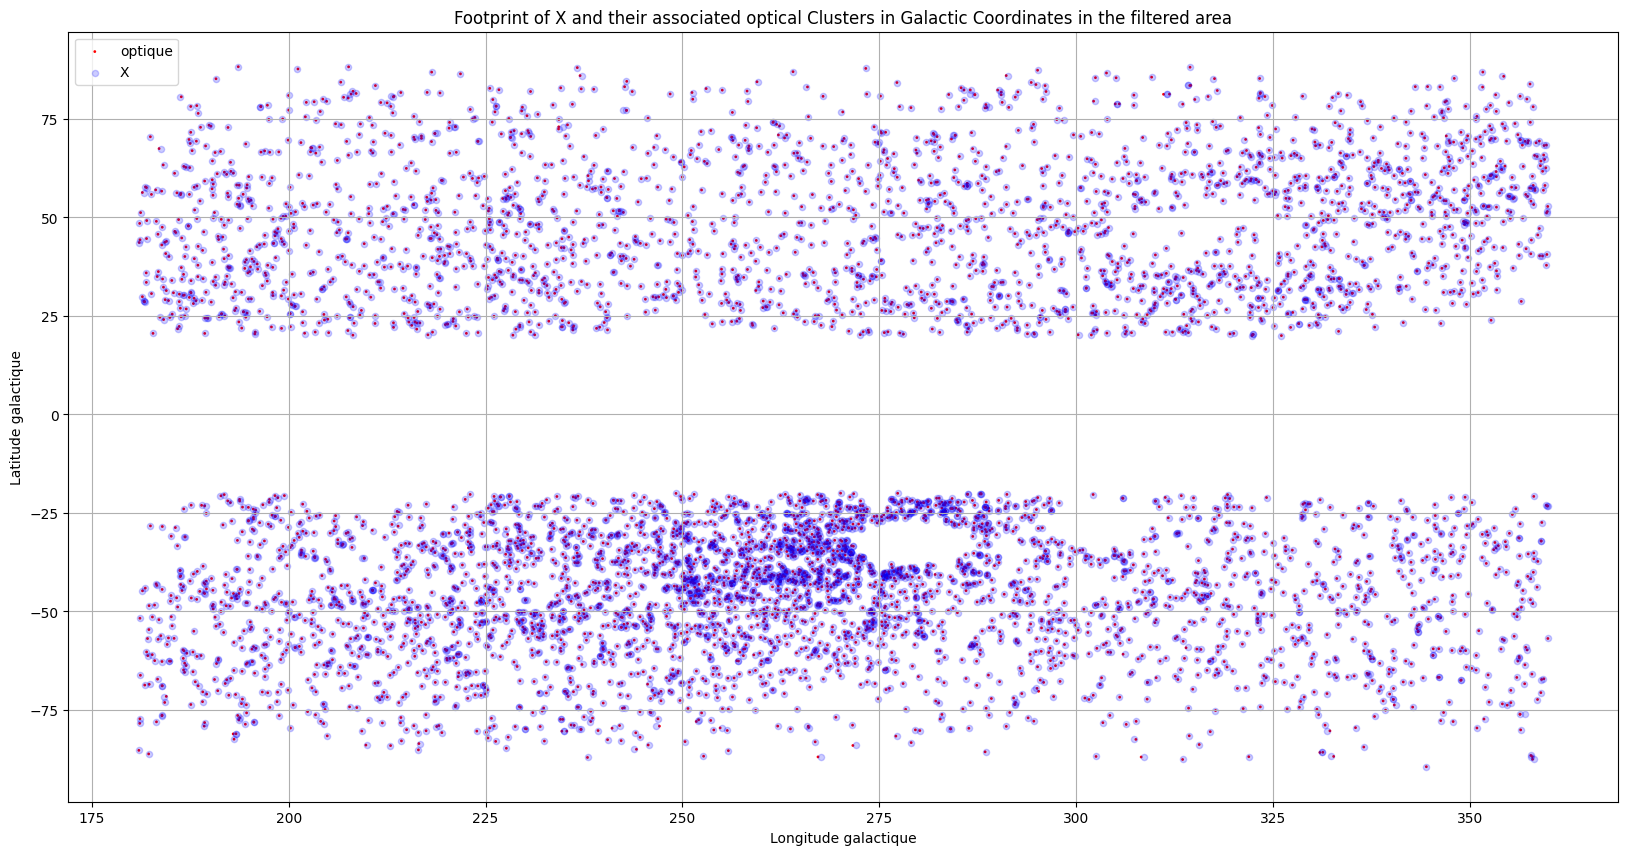

In [32]:
opt_glon_associated_3D = table_optique_associated_3D['glon'].tolist() ; opt_glat_associated_3D = table_optique_associated_3D['glat'].tolist()
X_glon_crossed_3D = table_X_crossed_3D['glon'].tolist() ; X_glat_crossed_3D = table_X_crossed_3D['glat'].tolist()


fig = plt.figure(figsize=(20, 10))
'''ax_projection_X = plt.subplot(111)
ax_projection_opt = plt.subplot(111)'''
ax_projection_X_ = plt.subplot(111)
ax_projection_opt_ = plt.subplot(111)


ax_projection_opt_.scatter(opt_glon_associated_3D, opt_glat_associated_3D,s=1,edgecolors='red',facecolors='none',label='optique') 
ax_projection_opt_.grid(True)
ax_projection_opt_.set_xlabel("Longitude galactique")
ax_projection_opt_.set_ylabel("Latitude galactique")

ax_projection_X_.scatter(X_glon_crossed_3D, X_glat_crossed_3D, s=20,facecolors='blue',alpha=0.2,label='X') 
ax_projection_X_.grid(True)
ax_projection_X_.set_xlabel("Longitude galactique")
ax_projection_X_.set_ylabel("Latitude galactique")


plt.title(f"Footprint of X and their associated optical Clusters in Galactic Coordinates in the filtered area")
plt.legend()


In [33]:
table_X_crossed_3D

,__indexes,glon,glat,_RAJ2000,_DEJ2000,Name,RAJ2000,DEJ2000,Exp,zBest,...,KT,Mgas500,YX500,M500,Fgas500,R500,id_asso_opt,diff_z,dist_ang,id_associations
2552,2552,209.634369,-50.384357,55.048567,-18.579460,1eRASS J034011.6-183446,55.048567,-18.579460,221.399994,0.0056,...,NaN,NaN,NaN,NaN,NaN,-2147483648,801100,0.0086,0.000999,"[2552, 801100]"
3833,3833,200.416033,-33.239623,67.917806,-5.084819,1eRASS J043140.2-050505,67.917806,-5.084819,146.399994,0.0160,...,NaN,NaN,NaN,NaN,NaN,-2147483648,240111,0.0004,0.002128,"[3833, 240111]"
4370,4370,201.358652,-27.735914,73.130685,-3.105706,1eRASS J045231.3-030620,73.130685,-3.105706,137.600006,0.0148,...,NaN,NaN,NaN,NaN,NaN,-2147483648,819392,0.0001,0.001053,"[4370, 819392]"
8094,8094,269.583941,26.491612,159.165881,-27.515430,1eRASS J103639.8-273055,159.165881,-27.515430,104.500000,0.0114,...,3.10,74.360001,231.18,15.840000,0.047,820,441160,0.0021,0.017430,"[8094, 441160]"
9528,9528,302.405192,21.557974,192.207279,-41.311106,1eRASS J124849.7-411839,192.207279,-41.311106,177.699997,0.0110,...,3.19,194.779999,623.62,26.990000,0.073,979,567180,0.0045,0.317038,"[9528, 567180]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4854,4854,235.223044,-33.386823,78.775357,-32.194606,1eRASS J051506.0-321140,78.775357,-32.194606,209.000000,1.0929,...,NaN,NaN,NaN,NaN,NaN,-2147483648,823507,0.0081,0.022545,"[4854, 823507]"
5480,5480,249.285537,-29.529085,86.669145,-43.138769,1eRASS J054640.5-430819,86.669145,-43.138769,262.100006,1.1281,...,2.07,228.070007,484.77,26.879999,0.078,640,828251,0.0039,0.018838,"[5480, 828251]"
11648,11648,337.381518,-40.221721,316.517336,-58.740395,1eRASS J210604.1-584425,316.517336,-58.740395,98.300003,1.1263,...,NaN,1137.420044,0.00,73.830002,0.153,898,698902,0.0048,0.007115,"[11648, 698902]"
3992,3992,260.902174,-41.204962,69.513577,-52.915845,1eRASS J043803.2-525457,69.513577,-52.915845,542.099976,1.1774,...,NaN,232.119995,0.00,20.240000,0.115,572,815954,0.0044,0.012338,"[3992, 815954]"


### table_X_crossed [DEPRECATED] (TO DO mettre à jour avec zone fiduciaire) 
Si un cluster A détecté en X est associé à 3 clusters détectés en optique, il n'y aura tout de même qu'une seule fois l'indice du cluster A dans la table "table_X_crossed" (pas de seuil sur la différence de z, association uniquement '2D').

In [ ]:
#Pour chaque objet X, on va identifier le nombre d'objets optiques associés, aisni que les indices de ces objets optiques

associations_dict_X = {}
for x in indices_X_crossed:
    associations_dict_X[x] = []
    for i in range(nb_bin_z):
        for float1, float2 in indices_crossed_list[i]:
            if float1 == x:
                associations_dict_X[x].append(float2)

#Maintenant, on va ajouter à chaque objet X le nombre d'objets optiques associés
for x in indices_X_crossed:
    num_associations = len(associations_dict_X[x])
    associations_dict_X[x] = (associations_dict_X[x], num_associations)

#On obtient un dictionnaire de la forme {indice_X : (indices_objets_optique, nombre_objets_optique_associés)}
'''print("Format de chaque entrée du dictionnaire : (indice_x) : ((liste_indices_optiques_associées),nombres d'objets dans l'optique associé) : ",'\n' )
associations_dict_X'''
            

'print("Format de chaque entrée du dictionnaire : (indice_x) : ((liste_indices_optiques_associées),nombres d\'objets dans l\'optique associé) : ",\'\n\' )\nassociations_dict_X'

Maintenant, on récupère dans la table X les objets qui ont une association :

In [ ]:
table_X_crossed = table_X.loc[indices_X_crossed] #; table_X_crossed = table_X_crossed.reset_index(drop=True) # On reset l'index pour ne pas avoir de mismacth dans les calculs par la suite
#table_optique_crossed = ta<<dble_optique.iloc[indices_optique_crossed] ; table_optique_crossed = table_optique_crossed.reset_index(drop=True)

In [ ]:
#On calcule les informations d'associations "diff_z" et "dist_ang" pour chaque objet X

diff_z_list = [] # Liste qui va contenir les différences de redshift entre l'objet X et l'ensemble des objets optiques associés
dist_ang_list = [] # Liste qui va contenir les distances angulaires entre l'objet X et l'ensemble des objets optiques associés
for index, x in table_X_crossed.iterrows():
    obj_opt_ass = associations_dict_X[index][0] #liste des objets optiques associés à l'objet X courant
    diff_z = []
    dist_ang = []
    for j in range(len(obj_opt_ass)): # On parcourt la liste des objets optiques associés à l'objet X
        diff_z.append(abs(table_X_crossed['zBest'][index] - table_optique_['zCl'][obj_opt_ass[j]]))
        dist_ang.append(np.sqrt((table_X_crossed['RAJ2000'][index] - table_optique_['RAJ2000'][obj_opt_ass[j]])**2 + (table_X_crossed['DEJ2000'][index] - table_optique_['DEJ2000'][obj_opt_ass[j]])**2)) 
    diff_z_list.append(diff_z) # On ajoute la liste des différences de redshift à la liste diff_z_list
    dist_ang_list.append(dist_ang)
    #print(f"Index: {index}, Element: {x}")
    #print(associations_dict_X[i])
    # print(associations_dict_X[index])
    #print(associations_dict_X[index][0][j])
    """diff_z.append(abs(table_X_crossed['zBest'][i] - table_optique['Z'][associations_dict_X[i][0]]))
    diff_z_list.append(diff_z)"""

In [ ]:
# On ajoute les informations d'associations à table_X_crossed. En comparaison de ce qu'a fait Reza on a : Nb_assos <-> idm ; id_assos <-> idass ; diff_z <-> delz ; dist_ang <-> dstass  

#Nb_assos :
nb_assos_list = [x[1][1] for x in associations_dict_X.items()]
table_X_crossed['nb_assos'] = nb_assos_list

#id_assos :
id_assos_list = [x[1][0] for x in associations_dict_X.items()]
table_X_crossed['id_assos'] = id_assos_list

#diff_z
table_X_crossed['diff_z'] = diff_z_list

#dist_ang
table_X_crossed['dist_ang'] = dist_ang_list


ValueError: Length of values (10724) does not match length of index (5912)

In [ ]:
# On crée la table "optique associée" en ne conservant que les objets optiques associés à un objet X

'flattened_list = [item for sublist in nested_list for item in sublist]'
id_assos_list_flatten = [id_assos for sublist in id_assos_list for id_assos in sublist] # On 'flatten' id_assos_list
table_optique_associated = table_optique.iloc[id_assos_list_flatten]

In [ ]:
# TO DO Sélection zone fiduciaire (comme pour table_X_crossed_3D) : problème ici la colonne 'id_assos' de table_X_crossed est une liste de listes

'''table_X_crossed['distance'] = np.sqrt((table_X_crossed['glon'] - x_center)**2 + (table_X_crossed['glat'] - y_center)**2)
table_X_crossed = table_X_crossed[table_X_crossed['distance'] >= radius_]
table_X_crossed = table_X_crossed.drop(columns=['distance'])



table_X_crossed = table_X_crossed[(table_X_crossed['glon'] > min_glon)
                                    & ((table_X_crossed['glat'] >= borne_1_glat_) | (table_X_crossed['glat'] <= borne_2_glat_))
                                    ]


table_optique_associated = table_optique_associated.loc[table_X_crossed['id_asso']]'''

"table_X_crossed['distance'] = np.sqrt((table_X_crossed['glon'] - x_center)**2 + (table_X_crossed['glat'] - y_center)**2)\ntable_X_crossed = table_X_crossed[table_X_crossed['distance'] >= radius_]\ntable_X_crossed = table_X_crossed.drop(columns=['distance'])\n\n\n\ntable_X_crossed = table_X_crossed[(table_X_crossed['glon'] > min_glon)\n                                    & ((table_X_crossed['glat'] >= borne_1_glat_) | (table_X_crossed['glat'] <= borne_2_glat_))\n                                    ]\n\n\ntable_optique_associated = table_optique_associated.loc[table_X_crossed['id_asso']]"

In [ ]:
table_X_crossed

,glon,glat,_RAJ2000,_DEJ2000,Name,RAJ2000,DEJ2000,Exp,zBest,e_zBest,...,KT,Mgas500,YX500,M500,Fgas500,R500,nb_assos,id_assos,diff_z,dist_ang
0,342.749448,-74.271284,0.021730,-38.624903,1eRASS J000005.2-383729,0.021730,-38.624903,94.800003,0.3153,0.0079,...,1.90,279.160004,553.19,36.070000,0.075,971,2,"[27, 761190]","[0.003399987792968684, 0.09009998779296868]","[0.0027952225038013205, 0.07225359652840475]"
1,304.840936,-34.106231,0.089191,-82.831715,1eRASS J000021.4-824954,0.089191,-82.831715,184.199997,0.0891,0.0002,...,NaN,111.919998,0.00,16.990000,0.065,819,6,"[351, 780, 759043, 759730, 759795, 761006]","[0.0029000032424926075, 0.9065999967575075, 0....","[0.09381977836727781, 0.2886274760528854, 358...."
2,322.452378,-65.003242,0.129422,-50.151013,1eRASS J000031.0-500903,0.129422,-50.151013,117.300003,0.0681,0.0002,...,1.79,1.920000,9.34,3.630000,0.009,493,8,"[37, 95, 267, 368, 403, 686, 760839, 761055]","[0.4808000020623209, 0.6743000020623208, 0.020...","[0.2053254781380665, 0.15284405528246822, 0.00..."
3,312.522364,-53.144800,0.132712,-63.025286,1eRASS J000031.8-630131,0.132712,-63.025286,139.600006,0.2448,0.0058,...,NaN,171.949997,0.00,22.040001,0.076,846,6,"[17, 232, 312, 454, 549, 761218]","[1.0079999986171722, 0.43289999861717227, 0.26...","[0.11824699455852168, 0.05171928880982598, 0.0..."
4,327.067389,-68.286560,0.189080,-46.394874,1eRASS J000045.3-462341,0.189080,-46.394874,109.500000,0.0925,0.0004,...,0.96,6.400000,11.17,3.780000,0.019,495,8,"[281, 369, 396, 475, 564, 758, 830, 761199]","[0.9199999988079071, 0.011699998807907105, 0.8...","[0.044561512148453136, 0.0029406834724008284, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12241,314.228009,-55.350263,359.741833,-60.612333,1eRASS J235858.0-603644,359.741833,-60.612333,142.500000,0.1052,0.0064,...,NaN,358.950012,0.00,38.669998,0.093,1071,9,"[760377, 760418, 760449, 760497, 760656, 76107...","[1.0618999998927117, 0.40649999989271174, 0.40...","[0.1982225668598602, 0.17155772599102595, 0.11..."
12242,317.972769,-60.279763,359.799123,-55.296727,1eRASS J235911.7-551748,359.799123,-55.296727,130.800003,0.2137,0.0063,...,NaN,5.590000,0.00,8.150000,0.008,614,3,"[760745, 760895, 761028]","[0.00010000352859498851, 0.162300003528595, 0....","[0.030274445132705663, 0.0474923715588338, 0.1..."
12243,357.004161,-76.739220,359.864701,-34.306012,1eRASS J235927.5-341821,359.864701,-34.306012,87.500000,0.1138,0.0004,...,NaN,81.230003,0.00,14.110000,0.054,763,4,"[12, 760908, 760949, 761041]","[0.30700000332593924, 0.1053000033259392, 0.20...","[359.85158417966386, 0.06551077657728839, 0.03..."
12244,330.823690,-70.028243,359.980381,-44.205215,1eRASS J235955.2-441218,359.980381,-44.205215,98.099998,0.5797,0.0117,...,NaN,41.310001,0.00,25.920000,0.020,785,1,[761124],[0.40150000686645504],[0.010890446519440915]


## Association optique → X

On utilise les mêmes paramètres que pour l'association X→optique : il s'avère que l'association optique→X (en tout cas pour les paramètres 30''/1 MPC/0.010 z) n'est pas équivalente à celle X→optique : voir la différence de nombre d'associations à la fin, on retrouve une différenc de quelques % voire inférieure à 1%.

### Calcul des indices

In [34]:
# On commence par créer des listes de coordonnées (RAJ2000,DEJ2000) en récupérant les colonnes correspondantes sur les tables

liste_indexes_optique_bins = []
liste_coords_optique_bins = []
for x in table_optique_list_bins:
    liste_indexes_opt_bin = []
    liste_coords_opt_bin = []
    for index,row in x.iterrows():         
        liste_indexes_opt_bin.append(index) ; liste_coords_opt_bin.append((row['RAJ2000'],row['DEJ2000']))
    liste_indexes_optique_bins.append(liste_indexes_opt_bin) ; liste_coords_optique_bins.append(liste_coords_opt_bin)

liste_coords_X_all = [] #Au contraire de liste_indexes_X, cette liste d'indexes ne sera pas coupé par bin de redshift
for index,row in table_X.iterrows():
    coord = (row['RAJ2000'],row['DEJ2000'])
    liste_coords_X_all.append(coord)

In [35]:
# TO DO ; trouver un moyen d'accélérer le calcul ! (voir cross_matching_X_optique _tentative_accel_calcul.ipynb)

folder_opt_X = '../DESI_eRass/indexes_crossed_opt_X/' # Dossier de sortie pour les indices croisés
print(name_indexes_crossed) #pour rappeler quels paramètres ont été utilisés

if RUN_opt_X :
    indices_crossed_opt_X = [] 
    for i in range(nb_bin_z):
        indices_crossed_opt_X_current = match_celestial_objects_list_deg(liste_coords_optique_bins[i],liste_coords_X_all,tol_ang_list[i])
        indices_crossed_opt_X.append(indices_crossed_opt_X_current)

        with open(os.path.join(folder_opt_X, name_indexes_crossed), 'wb') as file:
            pickle.dump(indices_crossed_opt_X, file)

#REMARQUE : Le calcul semble bcp plus rapide que dans le sens X→optique ! Avec les params  0.5 arcmin | 1 MPc | 0.010 deltaz :  2m30 dans le sens optique→X contre 1h30 dans le sens X→optique

SELECTED_0_5_arcmin__1_MPC__0_010_z.pkl


In [36]:
with open(os.path.join(folder_opt_X, name_indexes_crossed), 'rb') as file:
    indices_crossed_opt_X = pickle.load(file)

In [37]:
indices_crossed_opt_X_list = []

for i in range(nb_bin_z):
    indices_crossed_opt_X_list_bin = []
    for j in range(len(indices_crossed_opt_X[i])):
        indices_crossed_opt_X_list_bin.append([liste_indexes_optique_bins[i][indices_crossed_opt_X[i][j][0]],indices_crossed_opt_X[i][j][1]]) # le "vrai" indice X remplace celui qui permettait de le retrouver dans la liste des coordonnées par bin de redshift 
    indices_crossed_opt_X_list.append(indices_crossed_opt_X_list_bin)


In [38]:
# Ici, on récupère les indices pour chaque association, un indice optique est donc répété autant de fois que ce cluster est associé à un cluster X (si un cluster A détecté en optique est associé à 3 clusters détectés en X,
# il y aura 3 fois l'indices du cluster A dans la liste "indices_opt_crossed_repetitifs")
indices_opt_crossed_repetitifs = []
indices_X_repetitifs = []
for indices_crossed_opt_X_list_bin in indices_crossed_opt_X_list:
    for x in indices_crossed_opt_X_list_bin :
        indices_opt_crossed_repetitifs.append(x[0])
        indices_X_repetitifs.append(x[1])   

In [39]:
# Ici, on ne garde qu'une seule occurrence de chaque cluster optique associé à au moins un cluster X (si un cluster A détecté en optique est associé à 3 clusters détectés en X, il n'y aura tout de même qu'une seule fois l'indice
# du cluster A dans la liste "indices_opt_crossed")
number_of_duplicates_opt = 0
indices_opt_crossed = set()
for indices_crossed_opt_X_list_bin in indices_crossed_opt_X_list:
    for float1, float2 in indices_crossed_opt_X_list_bin:
        if float1 in indices_opt_crossed:
            number_of_duplicates_opt += 1
        else:
            indices_opt_crossed.add(float1)
indices_opt_crossed = sorted(indices_opt_crossed)
print(f"Proportion de duplicats par rapport an nombre de galaxies en optique: {round(number_of_duplicates_opt/len(table_X) * 100,3)} %")

Proportion de duplicats par rapport an nombre de galaxies en optique: 6.929 %


In [40]:
len(indices_opt_crossed_repetitifs)

16965

In [41]:
len(indices_X_crossed_repetitifs)

47612

### table_opt_crossed_3D

In [42]:
# Il peut y avoir plusieurs occurences d'un même objet X dans cette liste
table_opt_crossed_repetitifs = table_optique.loc[indices_opt_crossed_repetitifs]
table_opt_crossed_repetitifs['__indexes'] = indices_opt_crossed_repetitifs
# Reorder columns to place '__indexes' at the first position
table_opt_crossed_repetitifs = table_opt_crossed_repetitifs[['__indexes'] + [col for col in table_opt_crossed_repetitifs.columns if col != '__indexes']]

In [43]:
# On réindice pour que les indices correpondent à l'ordre des positions dans la table
table_X_ = table_X.reset_index(drop=True)
table_optique_ = table_optique.reset_index(drop=True)

diff_z_list_repetitif = []
dist_ang_list_repetitif = []

for i in range(len(table_opt_crossed_repetitifs)):
    index_opt = indices_opt_crossed_repetitifs[i] ; index_X = indices_X_repetitifs[i]

    Opt_row_of_interest = table_opt_crossed_repetitifs[table_opt_crossed_repetitifs['__indexes'] == index_opt].iloc[0] #On ne sélectionne qu'une seule ligne parmi ses éventuelles occurrences

    diff_z = abs(Opt_row_of_interest['zCl'] - table_X_.loc[index_X]['zBest']) 
    diff_z_list_repetitif.append(diff_z)
    dist_ang = np.sqrt((Opt_row_of_interest['RAJ2000'] - table_X_['RAJ2000'][index_X])**2 + (Opt_row_of_interest['DEJ2000'] - table_X_['DEJ2000'][index_X])**2)
    dist_ang_list_repetitif.append(dist_ang)
    
table_opt_crossed_repetitifs['id_asso_X'] = indices_X_repetitifs
table_opt_crossed_repetitifs['diff_z'] = diff_z_list_repetitif
table_opt_crossed_repetitifs['dist_ang'] = dist_ang_list_repetitif

# On applique le seuil de redshift pour ne conserver que les assocciations qui ne sont pas trop éloignées en redshift
table_opt_crossed_3D = table_opt_crossed_repetitifs[table_opt_crossed_repetitifs['diff_z'] < delta_z]
print(np.round((1-(len(table_opt_crossed_3D)/len(table_opt_crossed_repetitifs)))*100,1), " % des associations sont éliminées par le critère de redshift") 

#O récupère dans une table "table_X_associated_3D" les objets X associés à un objet optique
table_X_associated_3D = table_X_.loc[table_opt_crossed_3D['id_asso_X']]
table_X_associated_3D['id_asso_opt'] = table_opt_crossed_3D['__indexes'].tolist()

associations_opt_X = []
for index,x in table_opt_crossed_3D.iterrows():
    current_asso = [0,0]
    current_asso[0] = int(x['__indexes']) ; current_asso[1] = int(x['id_asso_X'])
    associations_opt_X.append(current_asso)

table_opt_crossed_3D['id_associations'] = associations_opt_X ; table_X_associated_3D['id_associations'] = associations_opt_X


# Sélection zone fiduciaire (pour éviter d'avoir des objets optiques dont l'association X a été précédemment filtrée ←→ séparation de couples)

seuil_fiduciaire = 1 
radius_ = radius + seuil_fiduciaire ; borne_1_glat_ = borne_1_glat - seuil_fiduciaire ; borne_2_glat_ = borne_2_glat + seuil_fiduciaire ; min_glon = min_glon + seuil_fiduciaire

table_opt_crossed_3D['distance'] = np.sqrt((table_opt_crossed_3D['glon'] - x_center)**2 + (table_opt_crossed_3D['glat'] - y_center)**2)
table_opt_crossed_3D = table_opt_crossed_3D[table_opt_crossed_3D['distance'] >= radius_]
table_opt_crossed_3D = table_opt_crossed_3D.drop(columns=['distance'])



table_opt_crossed_3D = table_opt_crossed_3D[(table_opt_crossed_3D['glon'] > min_glon)
                                    & ((table_opt_crossed_3D['glat'] <= borne_1_glat_) | (table_opt_crossed_3D['glat']>= borne_2_glat_))
                                    ]


table_X_associated_3D = table_X_associated_3D[table_X_associated_3D['id_associations'].isin(table_opt_crossed_3D['id_associations'].tolist())] # On ne conserve ques les associations dont les objets optiques sont dans la zone fiduciaire : cela permet d'éviter 
                                                                                                                                               # la séparation de couples (si le 'seuil_fiduciaire' est assez grand)

64.4  % des associations sont éliminées par le critère de redshift


C:\Users\ED282972\AppData\Local\Temp\ipykernel_12620\73385964.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_opt_crossed_3D['id_associations'] = associations_opt_X ; table_X_associated_3D['id_associations'] = associations_opt_X
C:\Users\ED282972\AppData\Local\Temp\ipykernel_12620\73385964.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_opt_crossed_3D['distance'] = np.sqrt((table_opt_crossed_3D['glon'] - x_center)**2 + (table_opt_crossed_3D['glat'] - y_center)**2)


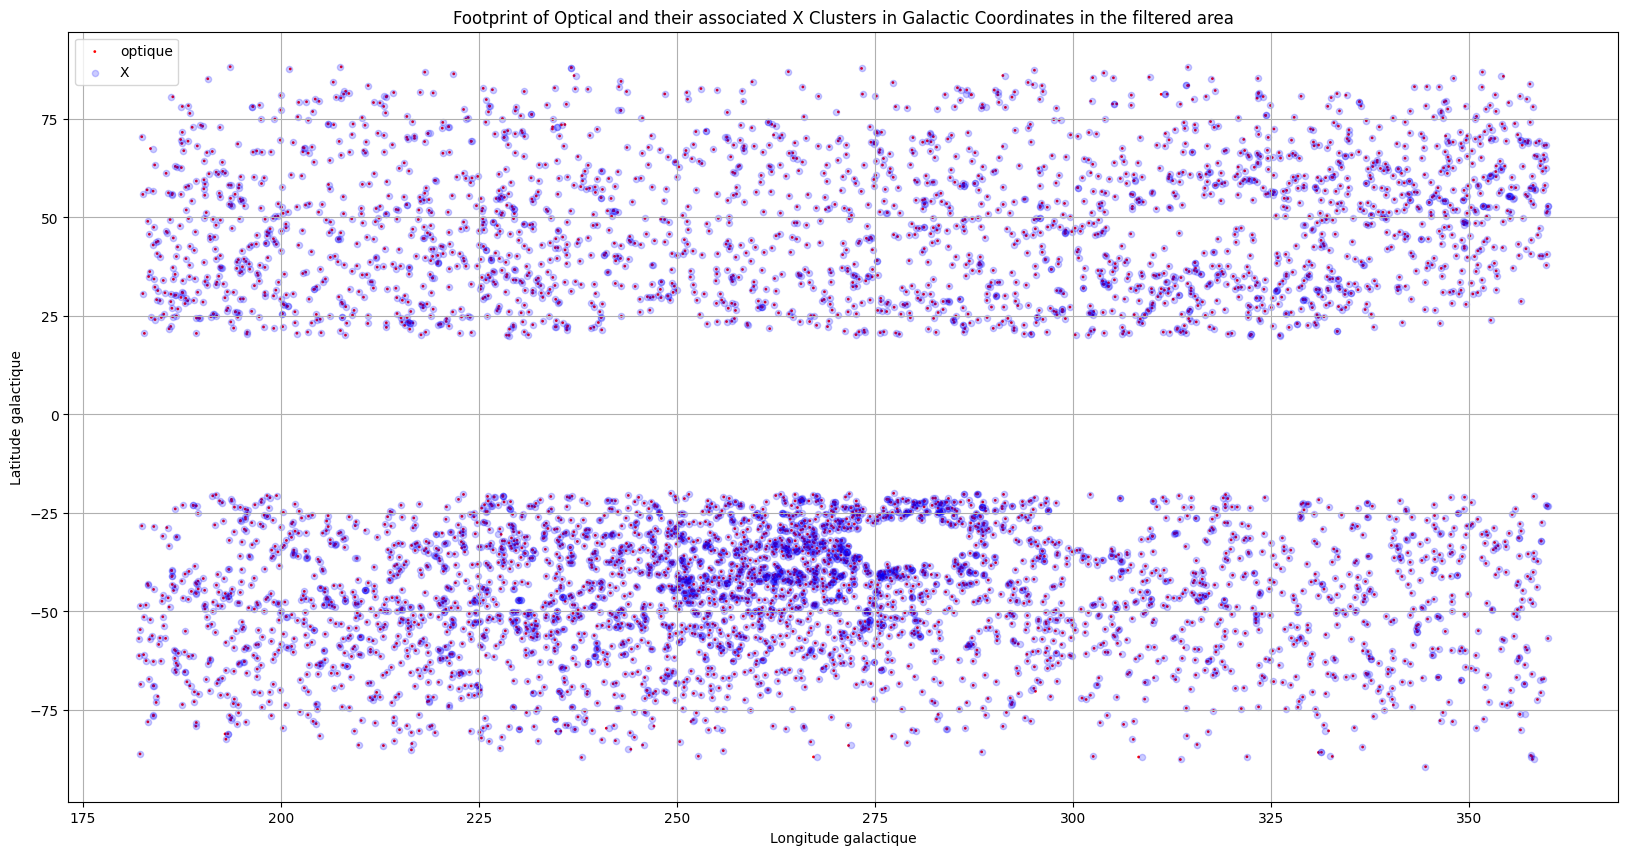

In [44]:
X_glon_associated_3D = table_X_associated_3D['glon'].tolist() ; X_glat_associated_3D = table_X_associated_3D['glat'].tolist()
opt_glon_crossed_3D = table_opt_crossed_3D['glon'].tolist() ; opt_glat_crossed_3D = table_opt_crossed_3D['glat'].tolist()


fig = plt.figure(figsize=(20, 10))
'''ax_projection_X = plt.subplot(111)
ax_projection_opt = plt.subplot(111)'''
ax_projection_X_ = plt.subplot(111)
ax_projection_opt_ = plt.subplot(111)


ax_projection_opt_.scatter(opt_glon_crossed_3D, opt_glat_crossed_3D,s=1,edgecolors='red',facecolors='none',label='optique') 
ax_projection_opt_.grid(True)
ax_projection_opt_.set_xlabel("Longitude galactique")
ax_projection_opt_.set_ylabel("Latitude galactique")

ax_projection_X_.scatter(X_glon_associated_3D, X_glat_associated_3D, s=20,facecolors='blue',alpha=0.2,label='X') 
ax_projection_X_.grid(True)
ax_projection_X_.set_xlabel("Longitude galactique")
ax_projection_X_.set_ylabel("Latitude galactique")


plt.title(f"Footprint of Optical and their associated X Clusters in Galactic Coordinates in the filtered area")
plt.legend()

In [45]:
if len(table_opt_crossed_3D) == len(table_X_crossed_3D):
    print("On a le même nombre d'associations dans le cas où on centre l'association autour d'un objet central X ou optique")
else :
    print("On a pas le même nombre d'associations dans le cas où on centre l'association autour d'un objet central X ou optique\n")
    print("Pourcentage de différence entre la méthode X→opt et la méthode opt→X : ",round((1-(len(table_opt_crossed_3D)/len(table_X_crossed_3D)))*100,1), " %")


On a pas le même nombre d'associations dans le cas où on centre l'association autour d'un objet central X ou optique

Pourcentage de différence entre la méthode X→opt et la méthode opt→X :  -0.6  %


# Visualisation résultats associations 

In [46]:
index_optique_associated_3D = table_optique_associated_3D.index.tolist()
table_optique_associated_3D['__indexes'] = index_optique_associated_3D
table_optique_associated_3D = table_optique_associated_3D[['__indexes'] + [col for col in table_optique_associated_3D.columns if col != '__indexes']]
table_optique_associated_3D

,__indexes,glon,glat,_RAJ2000,_DEJ2000,ID,n_Name,Name,RAJ2000,DEJ2000,...,lam500,M500,Ngal,Gamma,e_Gamma,imag_,Cat,recno,id_asso_X,id_associations
801100,801100,209.635642,-50.383836,55.04938,-18.58004,1065735,,J034011.9-183448,55.04938,-18.58004,...,25.88,11.8,6,0.0,0.0,2,CFSFDP,1065735,2552,"[2552, 801100]"
240111,240111,200.416500,-33.241710,67.91617,-5.08618,329686,WH-,J043139.9-050510,67.91617,-5.08618,...,12.46,5.8,9,0.0,0.0,1,,329686,3833,"[3833, 240111]"
819392,819392,201.358589,-27.736965,73.12974,-3.10617,1084027,WH-,J045231.1-030622,73.12974,-3.10617,...,10.86,5.1,9,0.0,0.0,2,,1084027,4370,"[4370, 819392]"
441160,441160,269.571465,26.480843,159.14868,-27.51825,530798,WH-,J103635.7-273106,159.14868,-27.51825,...,21.93,10.0,20,0.0,0.0,1,,530798,8094,"[8094, 441160]"
567180,567180,302.655197,21.489060,192.51630,-41.38195,657420,WH-,J125003.9-412255,192.51630,-41.38195,...,38.90,17.5,23,0.0,0.0,1,,657420,9528,"[9528, 567180]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823507,823507,235.229261,-33.405857,78.75488,-32.20404,1088142,WH-,J051501.2-321215,78.75488,-32.20404,...,11.69,5.4,7,0.0,0.0,2,,1088142,4854,"[4854, 823507]"
828251,828251,249.298715,-29.519147,86.68547,-43.14817,1092886,WH-,J054644.5-430853,86.68547,-43.14817,...,30.27,13.7,7,0.0,0.0,2,,1092886,5480,"[5480, 828251]"
698902,698902,337.373813,-40.222681,316.52188,-58.74587,827614,,J210605.3-584445,316.52188,-58.74587,...,34.87,15.7,20,0.0,0.0,1,WH22,827614,11648,"[11648, 698902]"
815954,815954,260.915480,-41.199667,69.51971,-52.92655,1080589,WH-,J043804.7-525536,69.51971,-52.92655,...,24.00,10.9,9,0.0,0.0,2,,1080589,3992,"[3992, 815954]"


In [47]:
table_optique_associated_3D.columns

Index(['__indexes', 'glon', 'glat', '_RAJ2000', '_DEJ2000', 'ID', 'n_Name',
       'Name', 'RAJ2000', 'DEJ2000', 'zCl', 'f_zCl', 'zmag', 'W1mag', 'logMs',
       'r500', 'lam500', 'M500', 'Ngal', 'Gamma', 'e_Gamma', 'imag_', 'Cat',
       'recno', 'id_asso_X', 'id_associations'],
      dtype='object')

In [48]:
table_X_crossed_3D.columns

Index(['__indexes', 'glon', 'glat', '_RAJ2000', '_DEJ2000', 'Name', 'RAJ2000',
       'DEJ2000', 'Exp', 'zBest', 'e_zBest', 'zType', 'pcont', 'CR300kpc',
       'CR500', 'CTS300kpc', 'CTS500', 'F500', 'L500', 'KT', 'Mgas500',
       'YX500', 'M500', 'Fgas500', 'R500', 'id_asso_opt', 'diff_z', 'dist_ang',
       'id_associations'],
      dtype='object')

In [49]:
# Dossier où stocker les plots
folder_plots = f"../DESI_eRass/figures/{name_indexes_crossed}/"
os.makedirs(folder_plots, exist_ok=True)

In [54]:
# Quantités intéressantes

diff_z = table_X_crossed_3D['diff_z'] # Différence de redshift entre l'objet X et l'objet optique associé
indexes_X_crossed_3D = table_X_crossed_3D['__indexes'] 

#Optique
N_gal = table_optique_associated_3D['Ngal']
richness = table_optique_associated_3D['lam500'] # Richness : mass proxy → define eq 2 in Wen 2024
M_500_opt = np.array(table_optique_associated_3D['M500'])


#X
M500_X = np.array(table_X_crossed_3D['M500'])
kT_X = np.array(table_X_crossed_3D['KT']) #Temperature en keV
CR500_X = np.array(table_X_crossed_3D['CR500']) # Count Rate en counts/s depuis la sphère de rayon R500
dz_x_mean = table_X_crossed_3D['e_zBest'].mean() # moyenne des erreurs de redshift des objets X

In [55]:
nb_nan_M_500_X = table_X_crossed_3D["M500"].isna().sum()
print(f"Nombre de valeurs NaN dans la colonne M500_X : {nb_nan_M_500_X}")

nb_nan_M_500_opt = table_optique_associated_3D["M500"].isna().sum()
print(f"Nombre de valeurs NaN dans la colonne M500_opt : {nb_nan_M_500_opt}")

Nombre de valeurs NaN dans la colonne M500_X : 638
Nombre de valeurs NaN dans la colonne M500_opt : 0


In [56]:
ratio_M500_X_opt = M500_X / M_500_opt
diff_M500_X_opt =((M500_X - M_500_opt) / M_500_opt)*100

In [ ]:
dDelta_r_list = [] # Liste qui va contenir les erreurs de la distance de ligne de visée (en valeur absolue) entre l'objet X et l'objet optique associé

for i in range(len(table_X_crossed_3D)):
    object_X = table_X_crossed_3D.iloc[i]
    object_opt = table_optique_associated_3D.iloc[i]

    z_x = object_X['zBest'] # Redshift objet X
    # Erreur sur le redshift de l'objet X
    dz_x = object_X['e_zBest']
    if np.isnan(dz_x): # On vérifie si la valeur est NaN
        dz_x = dz_x_mean # On remplace la valeur NaN par la moyenne des erreurs de redshift des objets X

    z_opt = object_opt['zCl'] # Redshift objet optique
    # Erreur sur le redshift de l'objet optique
    f_zCl = object_opt['f_zCl'] # Indique si le redshift est photométrique (f_zCl=0) ou spectroscopique (f_zCl=1)
    if f_zCl == 0: # redshift photométrique
        dz_opt = 0.010
    else: # redshift spectroscopique
        dz_opt = 0.00001 #Erreur caractéristique des redshifts spectroscopiques (A VERIFIER)

    Delta_r = (cosmo.angular_diameter_distance(z_x).value - cosmo.angular_diameter_distance(z_opt).value)

    #Delta_r_squared = (cosmo.angular_diameter_distance(z_x).value - cosmo.angular_diameter_distance(z_opt).value)**2
    #print(f"Delta_r_squared : {Delta_r_squared}")

    #Calcul numériqued de la dérivée de la distance de ligne de visée (choix de la distance de diamètre angulaire)
    #Pour les objets X
    r_x_plus = cosmo.angular_diameter_distance(z_x + dz_x).value
    r_x_minus = cosmo.angular_diameter_distance(z_x - dz_x).value
    dr_x = (r_x_plus - r_x_minus) / (2 * dz_x)  # Dérivée centrée

    #Pour les objets optiques
    r_opt_plus = cosmo.angular_diameter_distance(z_opt + dz_opt).value
    r_opt_minus = cosmo.angular_diameter_distance(z_opt - dz_opt).value
    dr_opt = (r_opt_plus - r_opt_minus) / (2 * dz_opt)  # Dérivée centrée

    #Calcul de l'erreur du CARRE de la distance de ligne de visée
    dDelta_r = dr_x*dz_x - dr_opt*dz_opt  
    dDelta_r_list.append(np.abs(dDelta_r))  # On ajoute l'erreur de la distance de ligne de visée à la liste


# Compter la proportion de NaN dans dDelta_r_list
dDelta_r_array = np.array(dDelta_r_list)
nb_nan = np.isnan(dDelta_r_array).sum()
proportion_nan = nb_nan / len(dDelta_r_array) * 100
print(f"Nombre de NaN : {nb_nan}")
print(f"Proportion de NaN : {proportion_nan:.2f} %")

C:\Users\ED282972\AppData\Local\Temp\ipykernel_12620\3624659918.py:30: RuntimeWarning: invalid value encountered in scalar divide
  dr_x = (r_x_plus - r_x_minus) / (2 * dz_x)  # Dérivée centrée


Nombre de NaN : 24
Proportion de NaN : 0.41 %


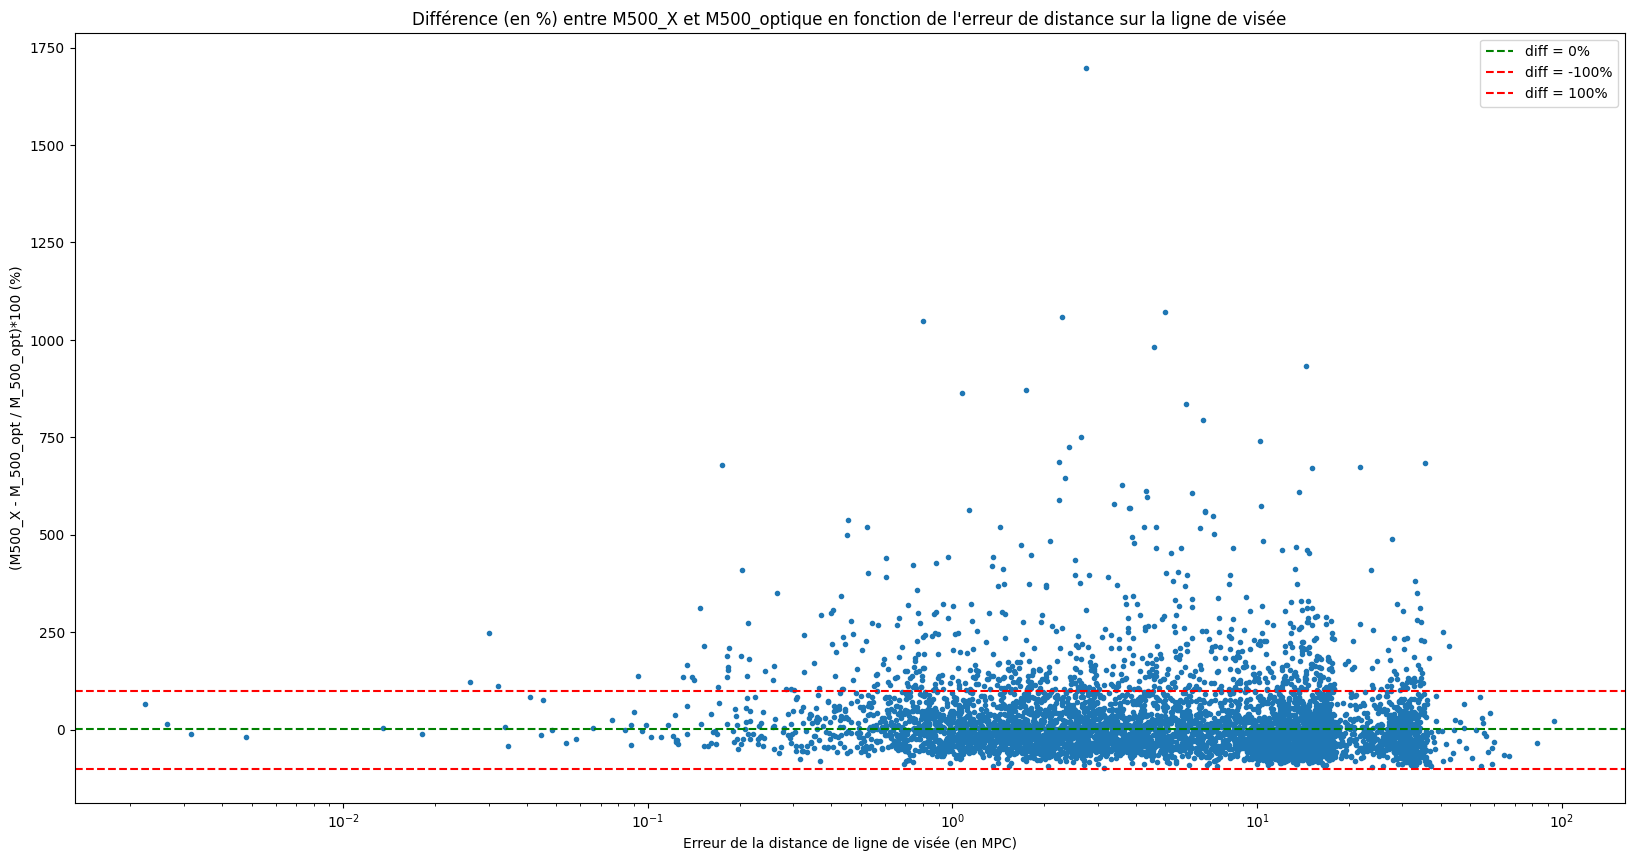

In [58]:
#On va afficher la différence de masse entre les deux éléments de l'association en fonction de la différence de l'erreur de la distance de ligne de visée
plt.figure(figsize=(20, 10))
plt.plot(dDelta_r_list, diff_M500_X_opt, 'o', markersize=3)
plt.axhline(y=1, color='green', linestyle='--', label=f'diff = 0%')
plt.axhline(y=-100, color='red', linestyle='--', label=f'diff = -100%')
plt.axhline(y=100, color='red', linestyle='--', label=f'diff = 100%')
plt.xlabel("Erreur de la distance de ligne de visée (en MPC)")
plt.ylabel('(M500_X - M_500_opt / M_500_opt)*100 (%)')
plt.title("Différence (en %) entre M500_X et M500_optique en fonction de l'erreur de distance sur la ligne de visée")
plt.xscale('log')
plt.legend()

output_path = os.path.join(folder_plots, "diff_M500_X_opt_vs_err_dist.png")
plt.savefig(output_path, dpi=300)

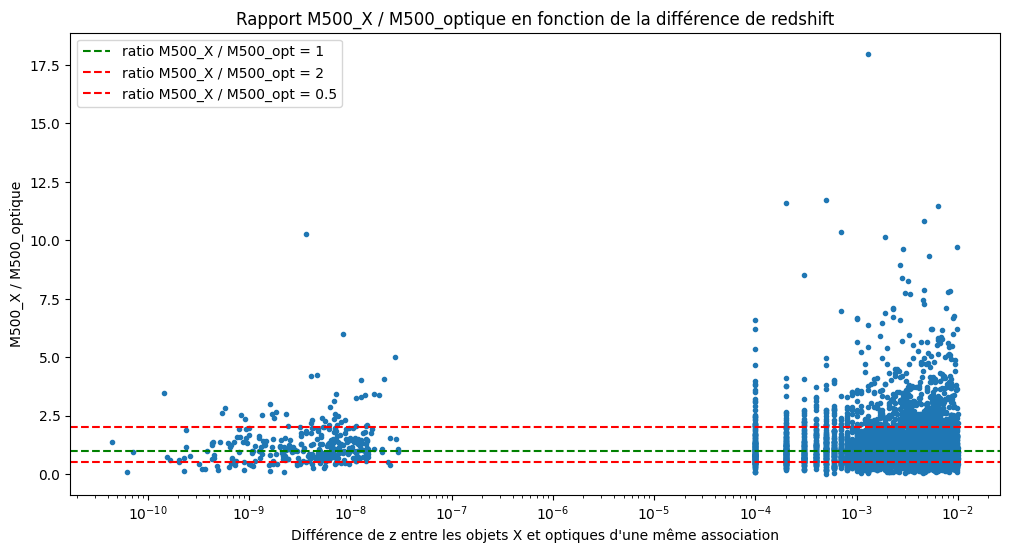

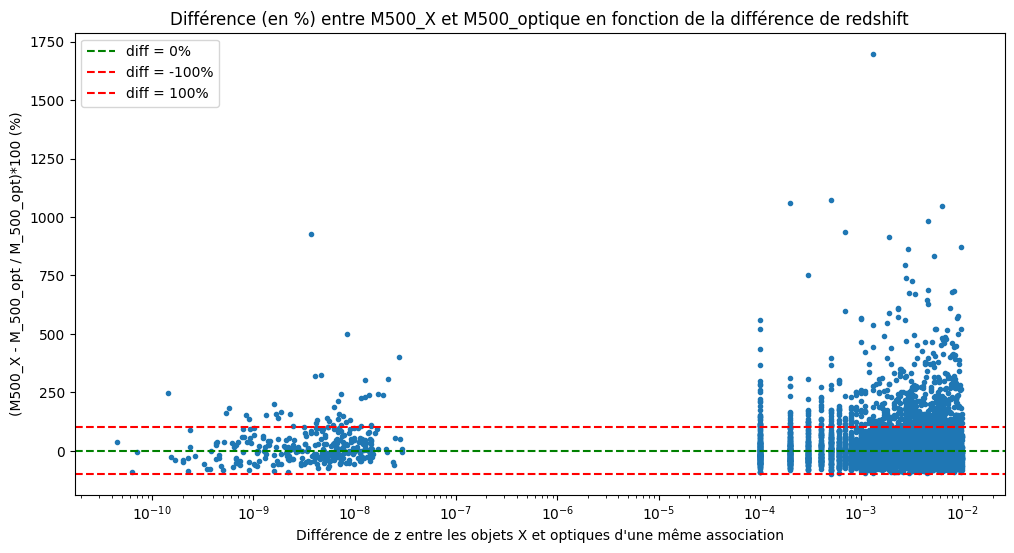

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(diff_z, ratio_M500_X_opt, 'o', markersize=3)
plt.axhline(y=1, color='green', linestyle='--', label=f'ratio M500_X / M500_opt = 1')
plt.axhline(y=2, color='red', linestyle='--', label=f'ratio M500_X / M500_opt = 2')
plt.axhline(y=0.5, color='red', linestyle='--', label=f'ratio M500_X / M500_opt = 0.5')
plt.xlabel("Différence de z entre les objets X et optiques d'une même association")
plt.ylabel('M500_X / M500_optique')
plt.title('Rapport M500_X / M500_optique en fonction de la différence de redshift')
plt.xscale('log')
plt.legend()

output_path = os.path.join(folder_plots, "ratio_M500_X_opt_vs_diff_z.png")
plt.savefig(output_path, dpi=300)

plt.figure(figsize=(12, 6))
plt.plot(diff_z, diff_M500_X_opt, 'o', markersize=3)
plt.axhline(y=1, color='green', linestyle='--', label=f'diff = 0%')
plt.axhline(y=-100, color='red', linestyle='--', label=f'diff = -100%')
plt.axhline(y=100, color='red', linestyle='--', label=f'diff = 100%')
plt.xlabel("Différence de z entre les objets X et optiques d'une même association")
plt.ylabel('(M500_X - M_500_opt / M_500_opt)*100 (%)')
plt.title('Différence (en %) entre M500_X et M500_optique en fonction de la différence de redshift')
plt.xscale('log')
plt.legend()

output_path = os.path.join(folder_plots, "diff_M500_X_opt_vs_diff_z.png")
plt.savefig(output_path, dpi=300)


In [60]:
# Dossier où stocker les plots
folder_plots = f"../DESI_eRass/figures/{name_indexes_crossed}/"
os.makedirs(folder_plots, exist_ok=True)

'output_path = os.path.join(folder_plots, "hist_nb_assos_par_objet_X.png")\nplt.savefig(output_path, dpi=300)'

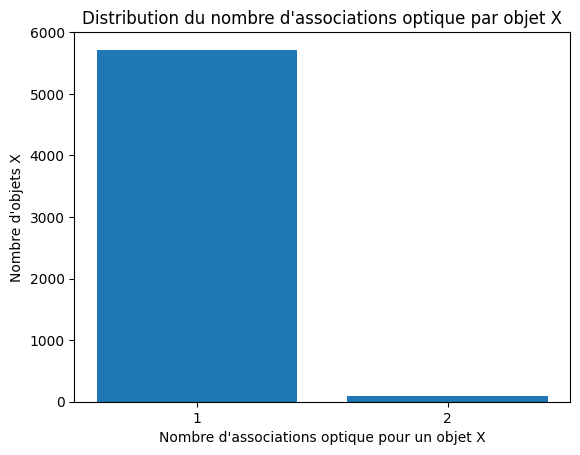

In [61]:
# Histogramme du nombre d'associations optique pour un objet X


# Compte le nombre d'occurrences de chaque index (nombre d'associations pour chaque objet X)
nb_assos_counter = Counter(indexes_X_crossed_3D) # dictionnaire avec les index X comme clés et le nombre d'associations optique comme valeurs
nb_assos_list = list(nb_assos_counter.values())


plt.figure()
bins = range(int(min(nb_assos_list)), int(max(nb_assos_list)) + 2)  # +2 pour inclure la dernière valeur entière
plt.hist(nb_assos_list, bins=bins, rwidth=0.8, align='left')
plt.xticks(range(int(min(nb_assos_list)), int(max(nb_assos_list)) + 1))
plt.xlabel("Nombre d'associations optique pour un objet X")
plt.ylabel("Nombre d'objets X")
plt.title("Distribution du nombre d'associations optique par objet X")

'''output_path = os.path.join(folder_plots, "hist_nb_assos_par_objet_X.png")
plt.savefig(output_path, dpi=300)'''

In [62]:
# Calcul proportion d'associations X → optique non-univoques
nb_asso_bins = list(Counter(nb_assos_list).values())
ratio_univoques = (nb_asso_bins[0] / len(indexes_X_crossed_3D)) * 100 
print(f"Proportion d'associations X → optique univoques : {round(ratio_univoques, 2)} %")

Proportion d'associations X → optique univoques : 96.72 %


'output_path = os.path.join(folder_plots, "richesse_optique_vs_M500.png")\nplt.savefig(output_path, dpi=300)'

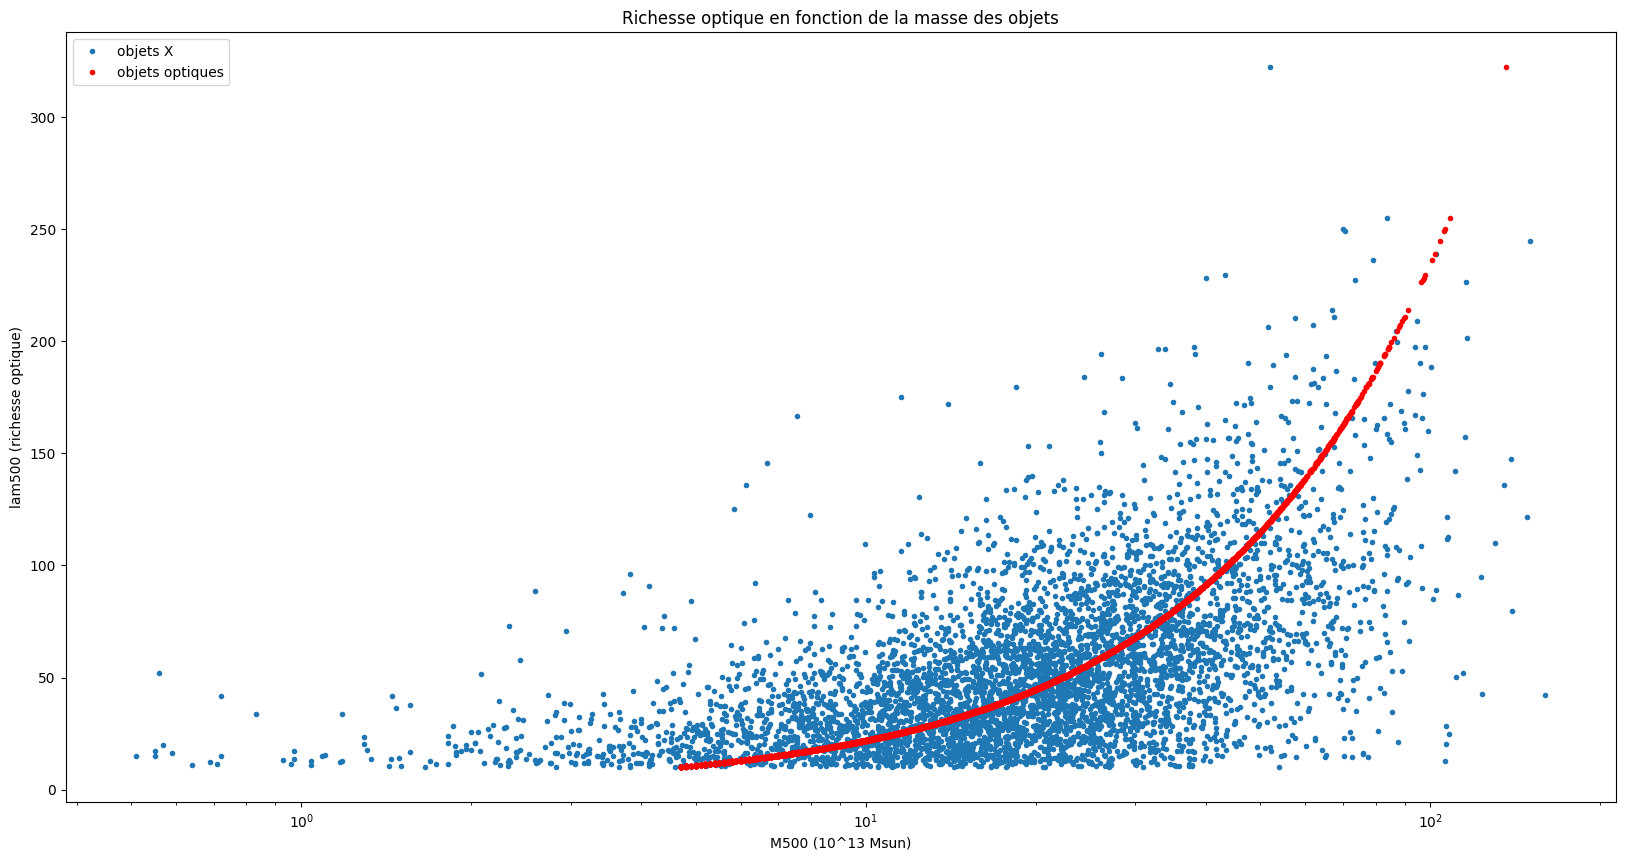

In [63]:
# graphe richesse optique - M500


plt.figure(figsize=(20, 10))
plt.plot(M500_X, richness, 'o', markersize=3,label='objets X')
plt.plot(M_500_opt, richness, 'o', color='red', markersize=3,label='objets optiques')
plt.xlabel('M500 (10^13 Msun)')
plt.ylabel('lam500 (richesse optique)')
plt.title('Richesse optique en fonction de la masse des objets')
plt.xscale('log')
plt.legend()

'''output_path = os.path.join(folder_plots, "richesse_optique_vs_M500.png")
plt.savefig(output_path, dpi=300)'''

In [64]:
borne_M_min = 10 ; borne_M_max = 50 # bornes de la masse M500 en 10^13 Msun
table_X_crossed_3D_filtered = table_X_crossed_3D[(table_X_crossed_3D['M500'] >= borne_M_min) & (table_X_crossed_3D['M500'] <= borne_M_max)]
table_optique_associated_3D_filtered = table_optique_associated_3D[table_optique_associated_3D['id_associations'].isin(table_X_crossed_3D_filtered['id_associations'].tolist())]

print(len(table_X_crossed_3D_filtered))
print(len(table_optique_associated_3D_filtered))


3878
3878


In [65]:
M500_X_filtered = table_X_crossed_3D_filtered['M500']
M500_opt_filtered = table_optique_associated_3D_filtered['M500']
richness_filtered = table_optique_associated_3D_filtered['lam500']
richness_filtered = table_optique_associated_3D_filtered['lam500']

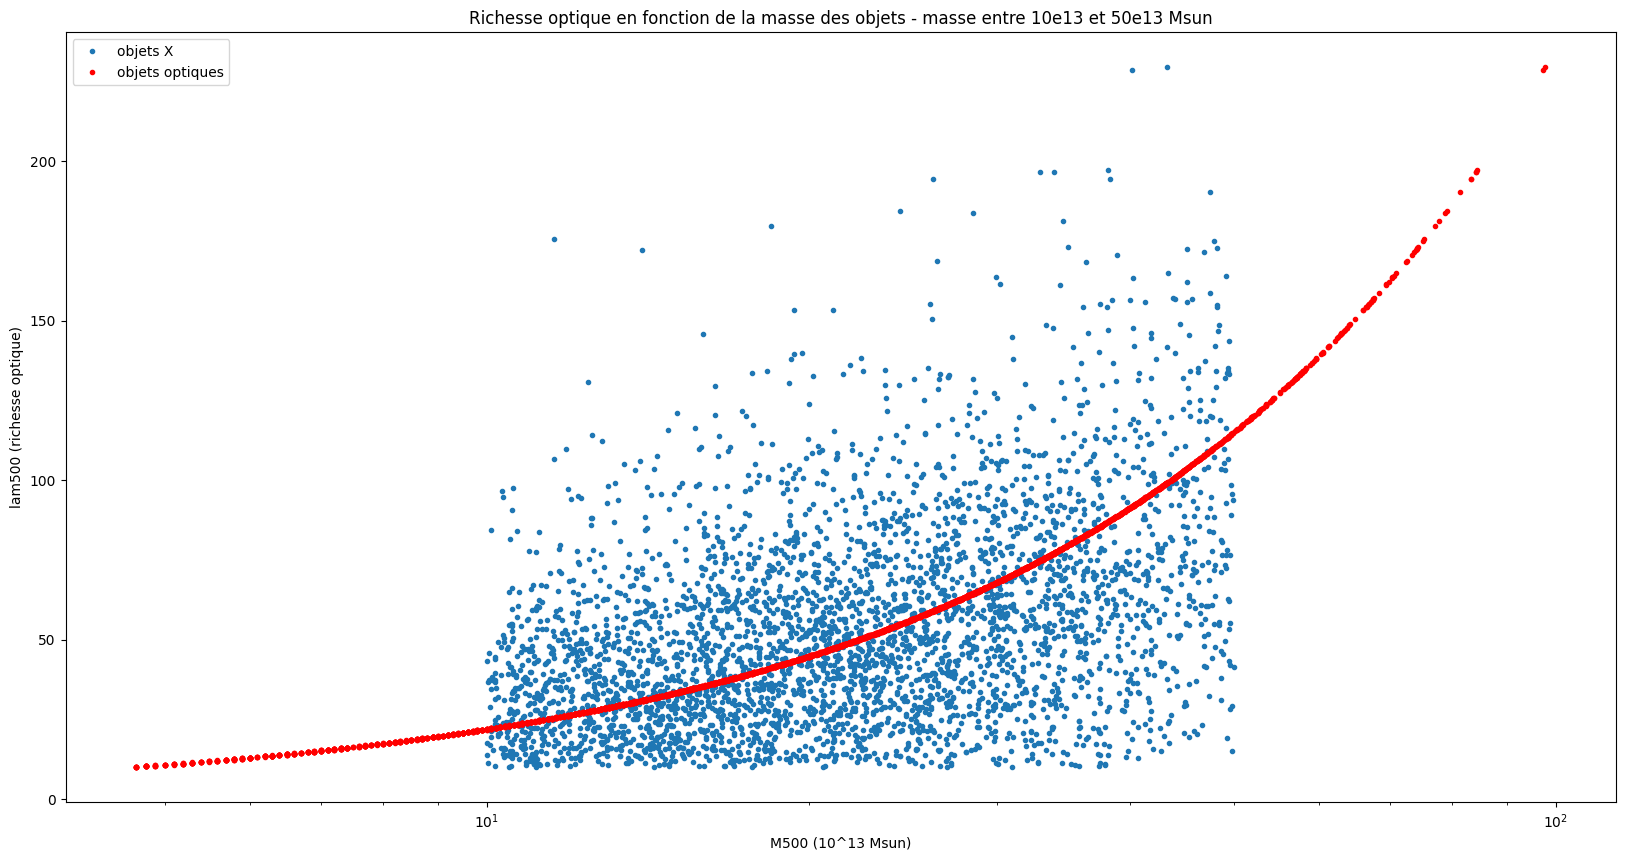

In [66]:
plt.figure(figsize=(20, 10))
plt.plot(M500_X_filtered, richness_filtered, 'o', markersize=3,label='objets X')
plt.plot(M500_opt_filtered, richness_filtered, 'o', color='red', markersize=3,label='objets optiques')
plt.xlabel('M500 (10^13 Msun)')
plt.ylabel('lam500 (richesse optique)')
plt.title(f'Richesse optique en fonction de la masse des objets - masse entre {borne_M_min}e13 et {borne_M_max}e13 Msun')
plt.xscale('log')
plt.legend()

'output_path = os.path.join(folder_plots, "richesse_optique_vs_M500.png")\nplt.savefig(output_path, dpi=300)'

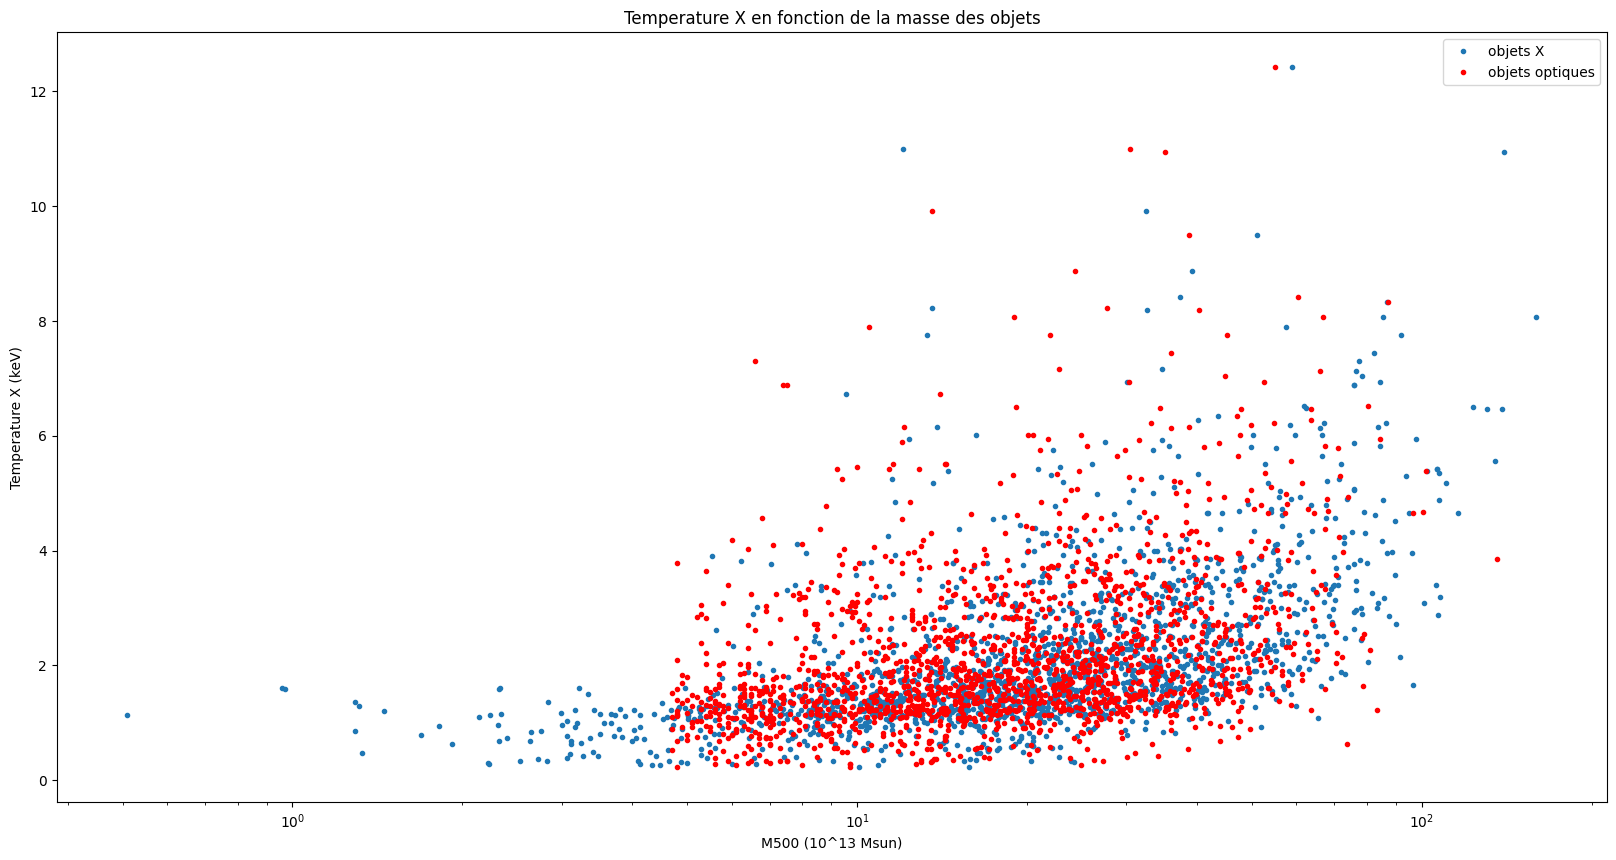

In [67]:
# graphe TX - M500


plt.figure(figsize=(20, 10))
plt.plot(M500_X, kT_X, 'o', markersize=3,label='objets X')
plt.plot(M_500_opt, kT_X, 'o', color='red', markersize=3,label='objets optiques')
plt.xlabel('M500 (10^13 Msun)')
plt.ylabel('Temperature X (keV)')
plt.title('Temperature X en fonction de la masse des objets')
plt.xscale('log')
plt.legend()

'''output_path = os.path.join(folder_plots, "richesse_optique_vs_M500.png")
plt.savefig(output_path, dpi=300)'''

'output_path = os.path.join(folder_plots, "count_rate_vs_M500.png")\nplt.savefig(output_path, dpi=300)'

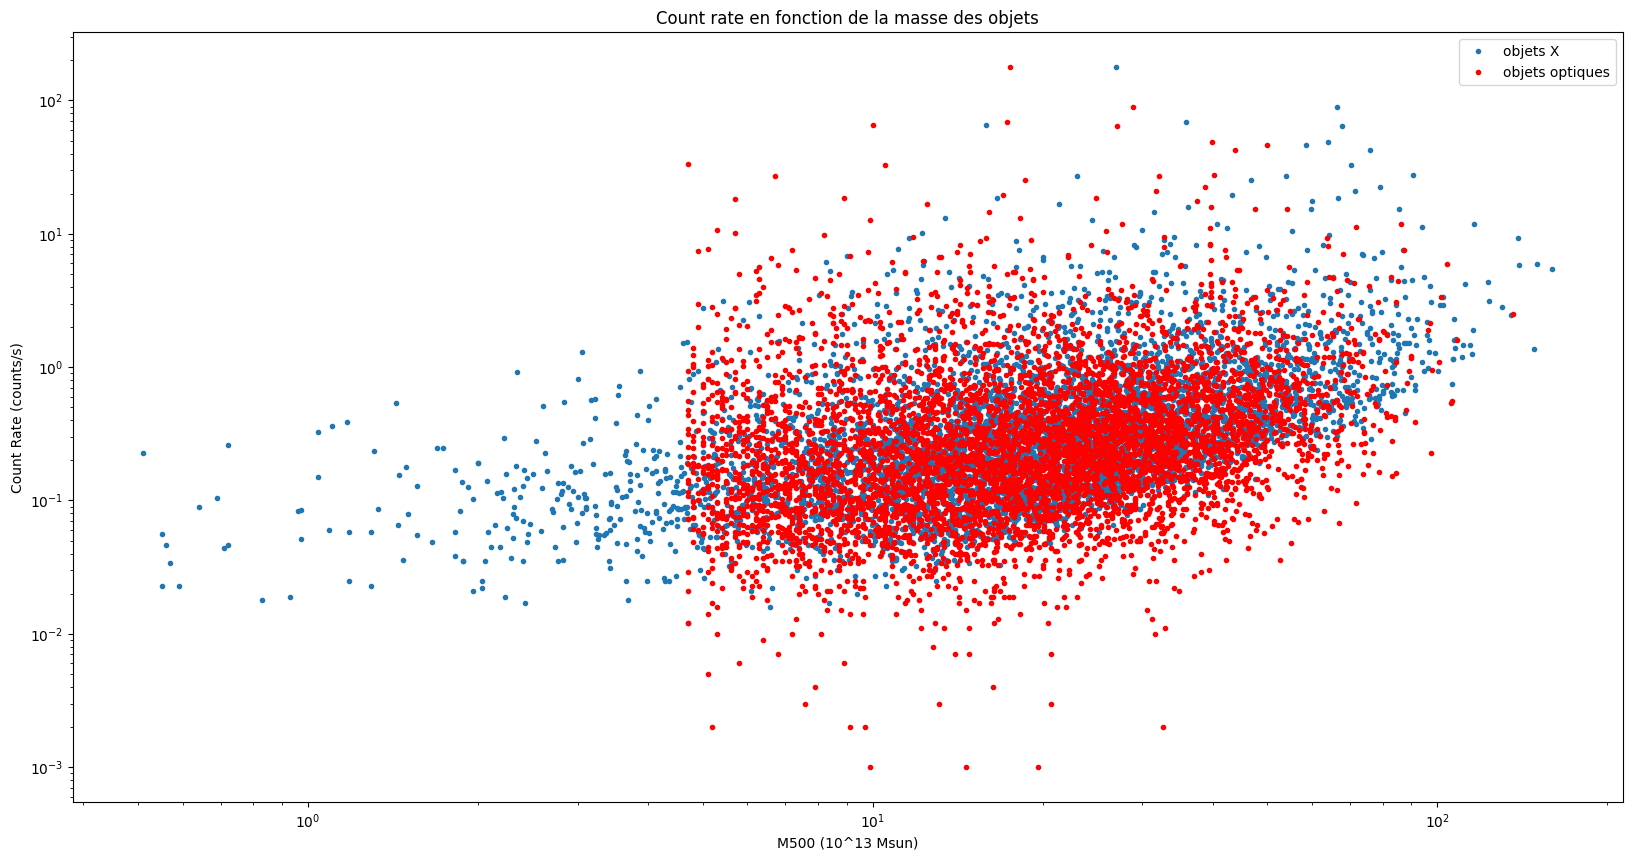

In [68]:
# graphe CR - M500 : scaling relation eq.25 p. 15 Ghirardini et al. 2024


plt.figure(figsize=(20, 10))
plt.plot(M500_X, CR500_X, 'o', markersize=3,label='objets X')
plt.plot(M_500_opt, CR500_X, 'o', color='red', markersize=3,label='objets optiques')
plt.xlabel('M500 (10^13 Msun)')
plt.ylabel('Count Rate (counts/s)')
plt.title('Count rate en fonction de la masse des objets')
plt.xscale('log')
plt.yscale('log')
plt.legend()

'''output_path = os.path.join(folder_plots, "count_rate_vs_M500.png")
plt.savefig(output_path, dpi=300)'''

'output_path = os.path.join(folder_plots, "richesse_optique_vs_M500.png")\nplt.savefig(output_path, dpi=300)'

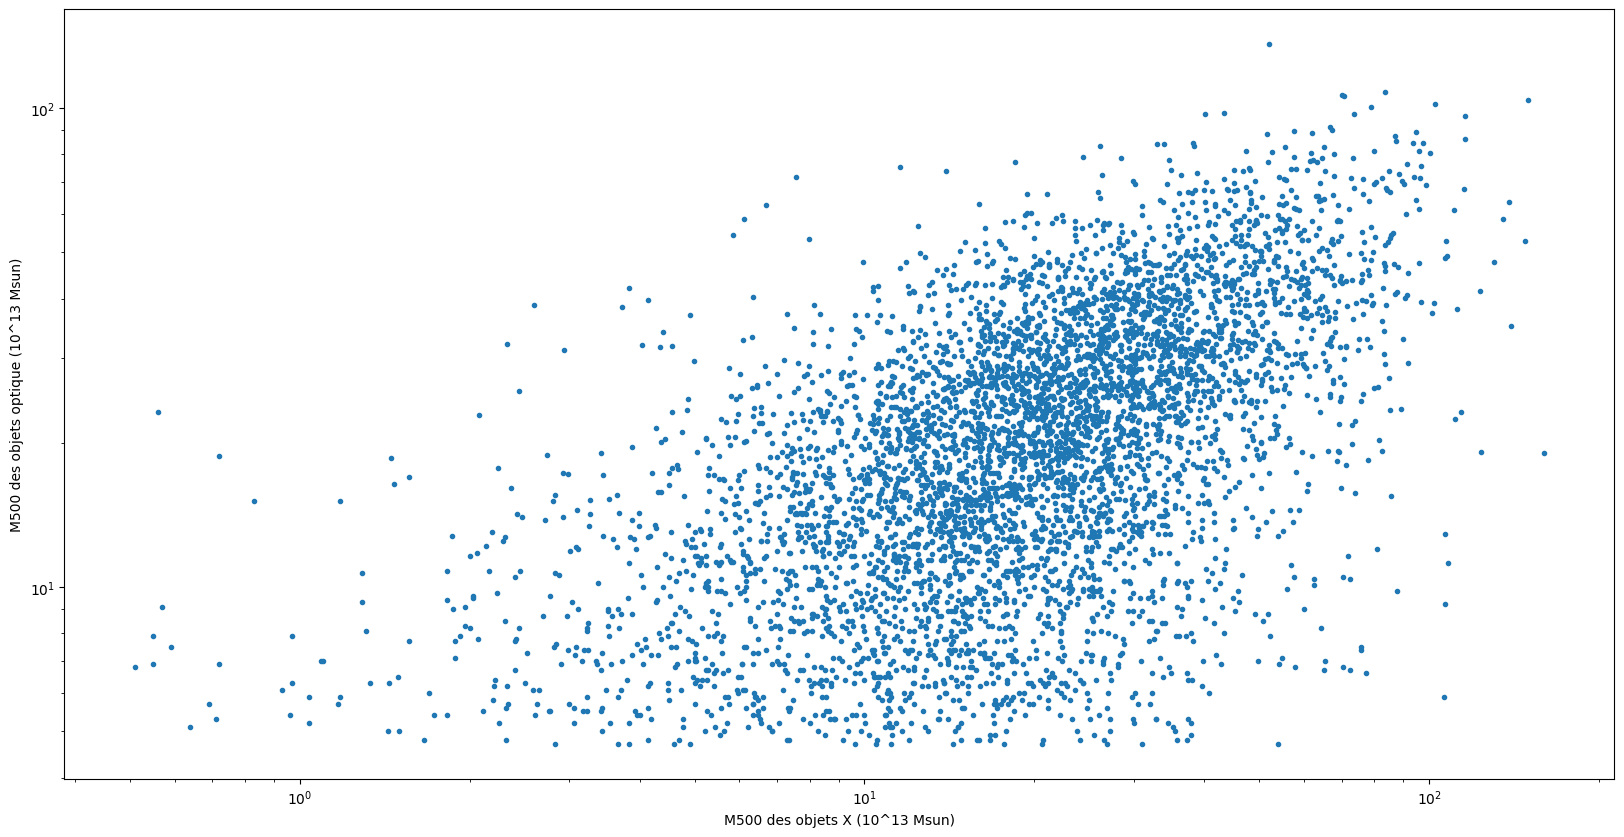

In [69]:
plt.figure(figsize=(20, 10))
plt.plot(M500_X, M_500_opt, 'o', markersize=3)
plt.xlabel('M500 des objets X (10^13 Msun)')
plt.ylabel('M500 des objets optique (10^13 Msun)')
plt.xscale('log')
plt.yscale('log')
'''output_path = os.path.join(folder_plots, "richesse_optique_vs_M500.png")
plt.savefig(output_path, dpi=300)'''

In [70]:
table_optique_associated_3D

,__indexes,glon,glat,_RAJ2000,_DEJ2000,ID,n_Name,Name,RAJ2000,DEJ2000,...,lam500,M500,Ngal,Gamma,e_Gamma,imag_,Cat,recno,id_asso_X,id_associations
801100,801100,209.635642,-50.383836,55.04938,-18.58004,1065735,,J034011.9-183448,55.04938,-18.58004,...,25.88,11.8,6,0.0,0.0,2,CFSFDP,1065735,2552,"[2552, 801100]"
240111,240111,200.416500,-33.241710,67.91617,-5.08618,329686,WH-,J043139.9-050510,67.91617,-5.08618,...,12.46,5.8,9,0.0,0.0,1,,329686,3833,"[3833, 240111]"
819392,819392,201.358589,-27.736965,73.12974,-3.10617,1084027,WH-,J045231.1-030622,73.12974,-3.10617,...,10.86,5.1,9,0.0,0.0,2,,1084027,4370,"[4370, 819392]"
441160,441160,269.571465,26.480843,159.14868,-27.51825,530798,WH-,J103635.7-273106,159.14868,-27.51825,...,21.93,10.0,20,0.0,0.0,1,,530798,8094,"[8094, 441160]"
567180,567180,302.655197,21.489060,192.51630,-41.38195,657420,WH-,J125003.9-412255,192.51630,-41.38195,...,38.90,17.5,23,0.0,0.0,1,,657420,9528,"[9528, 567180]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823507,823507,235.229261,-33.405857,78.75488,-32.20404,1088142,WH-,J051501.2-321215,78.75488,-32.20404,...,11.69,5.4,7,0.0,0.0,2,,1088142,4854,"[4854, 823507]"
828251,828251,249.298715,-29.519147,86.68547,-43.14817,1092886,WH-,J054644.5-430853,86.68547,-43.14817,...,30.27,13.7,7,0.0,0.0,2,,1092886,5480,"[5480, 828251]"
698902,698902,337.373813,-40.222681,316.52188,-58.74587,827614,,J210605.3-584445,316.52188,-58.74587,...,34.87,15.7,20,0.0,0.0,1,WH22,827614,11648,"[11648, 698902]"
815954,815954,260.915480,-41.199667,69.51971,-52.92655,1080589,WH-,J043804.7-525536,69.51971,-52.92655,...,24.00,10.9,9,0.0,0.0,2,,1080589,3992,"[3992, 815954]"


(array([ 998., 1914., 1194.,  839.,  577.,  218.,  118.,   42.,    7.,
           5.]),
 array([0.0135 , 0.13339, 0.25328, 0.37317, 0.49306, 0.61295, 0.73284,
        0.85273, 0.97262, 1.09251, 1.2124 ]),
 <BarContainer object of 10 artists>)

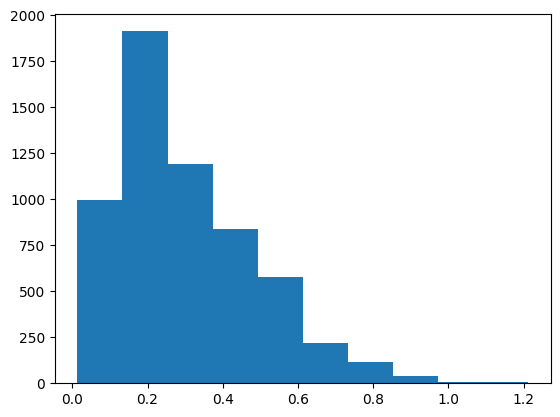

In [71]:
plt.hist(table_optique_associated_3D['zCl'])

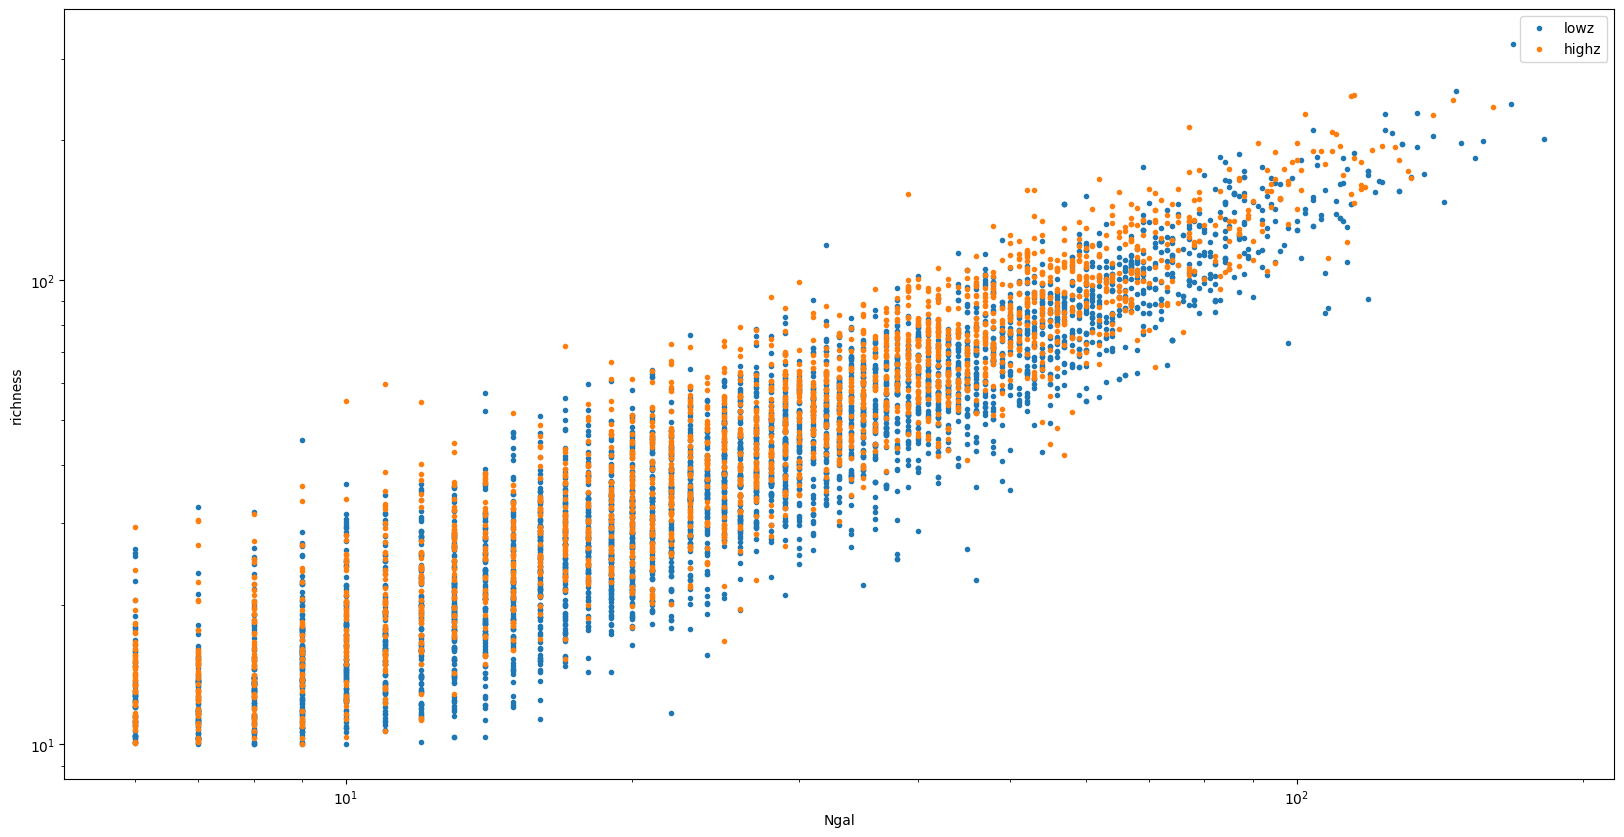

In [72]:
table_optique_associated_3D_low_z = table_optique_associated_3D[table_optique_associated_3D['zCl']<0.35]
table_optique_associated_3D_high_z = table_optique_associated_3D[table_optique_associated_3D['zCl']>0.35]


N_gal_low_z = table_optique_associated_3D_low_z['Ngal']
richness_low_z = table_optique_associated_3D_low_z['lam500']

N_gal_high_z = table_optique_associated_3D_high_z['Ngal']
richness_high_z = table_optique_associated_3D_high_z['lam500']


plt.figure(figsize=(20, 10))
plt.plot(N_gal_low_z, richness_low_z, 'o', markersize=3,label='lowz')
plt.plot(N_gal_high_z, richness_high_z, 'o', markersize=3,label='highz')
plt.xlabel('Ngal')
plt.ylabel('richness')
plt.xscale('log')
plt.yscale('log')
plt.legend()

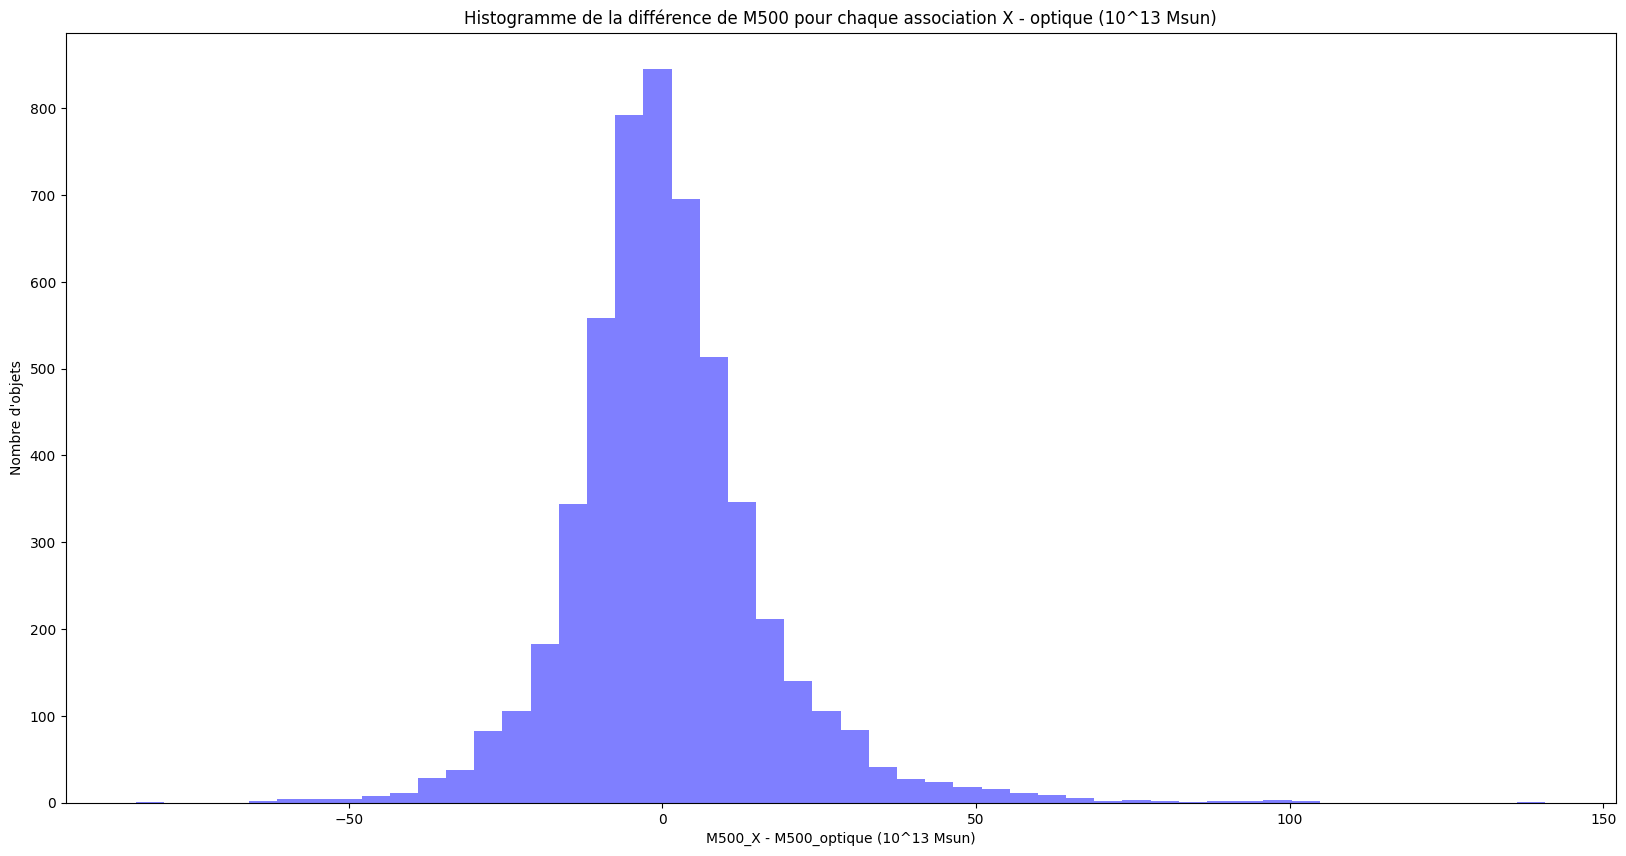

In [73]:
# Histogramme M500_X - M500_optique
diff_mass = M500_X - M_500_opt

plt.figure(figsize=(20, 10))
plt.hist(diff_mass, bins=50, color='blue', alpha=0.5)
plt.xlabel('M500_X - M500_optique (10^13 Msun)')
plt.ylabel('Nombre d\'objets')
plt.title('Histogramme de la différence de M500 pour chaque association X - optique (10^13 Msun)')

output_path = os.path.join(folder_plots, "histogramme_diff_M500.png")
plt.savefig(output_path, dpi=300)

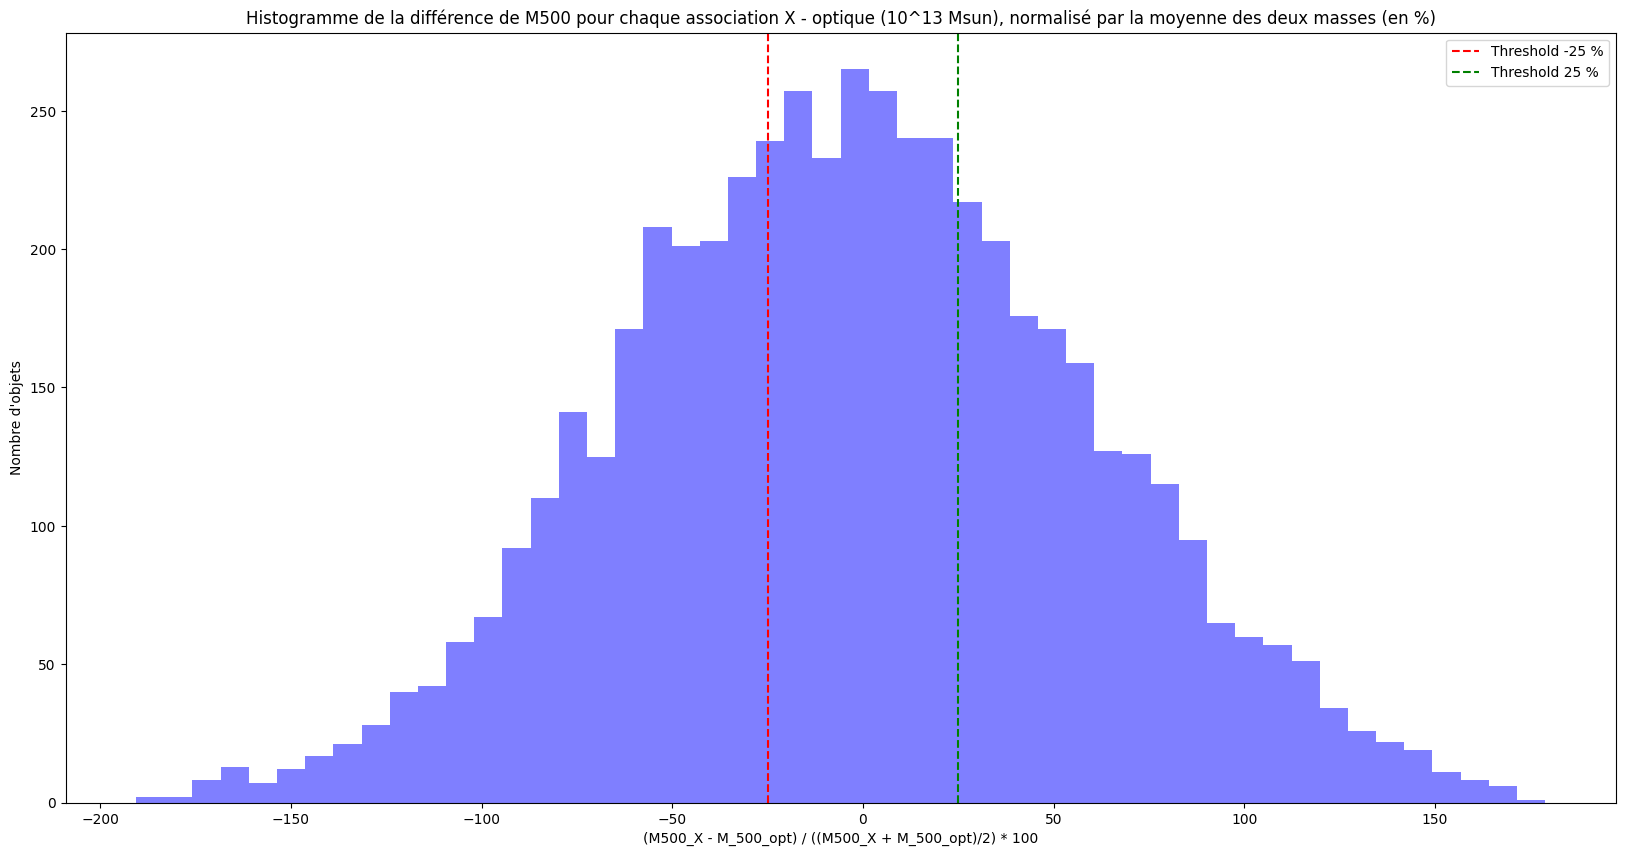

In [74]:
diff_mass_normalisée = ((M500_X - M_500_opt) / ((M500_X + M_500_opt)/2))*100


plt.figure(figsize=(20, 10))
plt.hist(diff_mass_normalisée , bins=50, color='blue', alpha=0.5)

# Add thresholds
threshold1 = -25  # Example threshold
threshold2 = 25   # Example threshold
plt.axvline(x=threshold1, color='red', linestyle='--', label=f'Threshold {threshold1} %')
plt.axvline(x=threshold2, color='green', linestyle='--', label=f'Threshold {threshold2} %')

plt.xlabel('(M500_X - M_500_opt) / ((M500_X + M_500_opt)/2) * 100')
plt.ylabel('Nombre d\'objets')
plt.title('Histogramme de la différence de M500 pour chaque association X - optique (10^13 Msun), normalisé par la moyenne des deux masses (en %)')

plt.legend()

output_path = os.path.join(folder_plots, "histogramme_diff_M500_normalisée.png")
plt.savefig(output_path, dpi=300)

In [75]:
# on récupère les indices des associations dont la différence de masse normalisée est supérieure à 25% (en valeur absolue)
suspect_associations_mass = []
for i in range(len(diff_mass_normalisée)):
    if abs(diff_mass_normalisée[i]) > 25:
        suspect_associations_mass.append(i)

suspect_associations_mass_indexes = np.zeros((len(suspect_associations_mass), 2))  # Initialize a 2D array with zeros
i = 0
for x in suspect_associations_mass:
    suspect_associations_mass_indexes[i][0] = table_X_crossed_3D.iloc[x].name
    suspect_associations_mass_indexes[i][1] = table_optique_associated_3D.iloc[x].name
    i += 1
suspect_associations_mass_indexes
suspect_associations_mass_indexes_X = suspect_associations_mass_indexes[:,0].astype(int)
suspect_associations_mass_indexes_opt = suspect_associations_mass_indexes[:,1].astype(int)

output_proportion_associations_suspectes = f"Proportion d'associations suspectes en termes de différences de masse par rapport au nombre total d'associations : {round(len(suspect_associations_mass)/len(diff_mass_normalisée)*100,3)} %"
print(output_proportion_associations_suspectes)

output_path = os.path.join(folder_plots, 'proportion_associations_suspectes.txt')
with open(output_path, 'w') as f:
    f.write(output_proportion_associations_suspectes)

Proportion d'associations suspectes en termes de différences de masse par rapport au nombre total d'associations : 60.944 %


In [76]:
suspect_associations_mass_indexes
table_X_crossed_3D_suspect = table_X_crossed_3D.loc[suspect_associations_mass_indexes_X] # On récupère les objets X des associations suspectes
table_optique_associated_3D_suspect = table_optique_associated_3D.loc[suspect_associations_mass_indexes_opt] # On récupère les objets optiques des associations suspectes

In [77]:
table_X_crossed_3D_suspect

,__indexes,glon,glat,_RAJ2000,_DEJ2000,Name,RAJ2000,DEJ2000,Exp,zBest,...,KT,Mgas500,YX500,M500,Fgas500,R500,id_asso_opt,diff_z,dist_ang,id_associations
8094,8094,269.583941,26.491612,159.165881,-27.515430,1eRASS J103639.8-273055,159.165881,-27.515430,104.500000,0.0114,...,3.10,74.360001,231.18,15.840000,0.047,820,441160,2.100000e-03,0.017430,"[8094, 441160]"
9528,9528,302.405192,21.557974,192.207279,-41.311106,1eRASS J124849.7-411839,192.207279,-41.311106,177.699997,0.0110,...,3.19,194.779999,623.62,26.990000,0.073,979,567180,4.500000e-03,0.317038,"[9528, 567180]"
10418,10418,349.732797,65.498244,210.700883,9.338199,1eRASS J140248.2+092017,210.700883,9.338199,151.199997,0.0197,...,1.13,0.570000,1.26,0.510000,0.014,260,623521,6.258480e-11,0.003607,"[10418, 623521]"
219,219,306.170637,-60.907988,10.032887,-56.149109,1eRASS J004007.8-560856,10.032887,-56.149109,143.399994,0.0282,...,1.45,60.000000,90.41,10.870000,0.055,719,20560,7.000005e-04,0.182781,"[219, 20560]"
407,407,293.107098,-70.845207,17.476610,-45.929117,1eRASS J010954.3-455544,17.476610,-45.929117,115.199997,0.0238,...,2.35,90.449997,216.31,13.420000,0.067,773,37923,1.999999e-03,0.005288,"[407, 37923]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10573,10573,327.688486,36.090096,214.364295,-22.612362,1eRASS J141727.4-223644,214.364295,-22.612362,167.000000,1.0334,...,3.16,297.000000,1154.84,36.070000,0.077,733,633209,8.900059e-03,0.005060,"[10573, 633209]"
5663,5663,269.268949,-29.650074,89.945854,-60.381185,1eRASS J055947.0-602252,89.945854,-60.381185,818.099976,1.0426,...,2.25,291.130005,700.89,25.190001,0.115,648,314862,7.199964e-03,0.003085,"[5663, 314862]"
5480,5480,249.285537,-29.529085,86.669145,-43.138769,1eRASS J054640.5-430819,86.669145,-43.138769,262.100006,1.1281,...,2.07,228.070007,484.77,26.879999,0.078,640,828251,3.900038e-03,0.018838,"[5480, 828251]"
11648,11648,337.381518,-40.221721,316.517336,-58.740395,1eRASS J210604.1-584425,316.517336,-58.740395,98.300003,1.1263,...,NaN,1137.420044,0.00,73.830002,0.153,898,698902,4.800023e-03,0.007115,"[11648, 698902]"


In [78]:
table_optique_associated_3D_suspect

,__indexes,glon,glat,_RAJ2000,_DEJ2000,ID,n_Name,Name,RAJ2000,DEJ2000,...,lam500,M500,Ngal,Gamma,e_Gamma,imag_,Cat,recno,id_asso_X,id_associations
441160,441160,269.571465,26.480843,159.14868,-27.51825,530798,WH-,J103635.7-273106,159.14868,-27.51825,...,21.93,10.0,20,0.00,0.00,1,,530798,8094,"[8094, 441160]"
567180,567180,302.655197,21.489060,192.51630,-41.38195,657420,WH-,J125003.9-412255,192.51630,-41.38195,...,38.90,17.5,23,0.00,0.00,1,,657420,9528,"[9528, 567180]"
623521,623521,349.740923,65.499498,210.70262,9.34136,716174,,J140248.6+092029,210.70262,9.34136,...,14.76,6.8,14,0.00,0.00,1,CFSFDP,716174,10418,"[10418, 623521]"
20560,20560,305.964340,-60.851501,10.20370,-56.21416,43649,,J004048.9-561251,10.20370,-56.21416,...,15.92,7.3,11,0.00,0.00,1,CFSFDP,43649,219,"[219, 20560]"
37923,37923,293.098323,-70.842500,17.48150,-45.93113,80769,,J010955.6-455552,17.48150,-45.93113,...,40.61,18.2,30,0.38,0.03,1,CFSFDP,80769,407,"[407, 37923]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633209,633209,327.694250,36.091289,214.36839,-22.60939,726846,WH-,J141728.4-223634,214.36839,-22.60939,...,59.69,26.5,11,0.00,0.00,1,,726846,10573,"[10573, 633209]"
314862,314862,269.272017,-29.650960,89.94439,-60.38390,404471,,J055946.7-602302,89.94439,-60.38390,...,37.19,16.7,18,0.00,0.00,1,WH22,404471,5663,"[5663, 314862]"
828251,828251,249.298715,-29.519147,86.68547,-43.14817,1092886,WH-,J054644.5-430853,86.68547,-43.14817,...,30.27,13.7,7,0.00,0.00,2,,1092886,5480,"[5480, 828251]"
698902,698902,337.373813,-40.222681,316.52188,-58.74587,827614,,J210605.3-584445,316.52188,-58.74587,...,34.87,15.7,20,0.00,0.00,1,WH22,827614,11648,"[11648, 698902]"
